# Proyecto: Equipo 13
- Richard Bolaños: (richardfelipe@hotmail.com)
- Juan Sebastian Garzón D''aleman: (sebastiangd23@gmail.com)
- Juan Maya: (jcmayac@gmail.com)

Instructor:
- Daniel Muñoz Palma (palma8904@gmail.com)

## Objetivo
Predecir si una paciente (mujer) mayor a 21 años desarrollará diabetes Mielitus tipo II


# Datos
Tomados de: https://www.kaggle.com/datasets/mathchi/diabetes-data-set

El dataset, tomado de National Institute of Diabetes and Digestive and Kidney Diseases, contiene la información sobre 768 pacientes mujeres mayores a 21 años junto con 8 indices médicos de resumen y su clasificación en dos grupos: Pacientes diagnosticadas con diabetes y pacientes libres de diabetes.

A continuación, una breve descripción de las variables incluidas en el dataset:

- __pregnancies__: Número de veces embarazada
- __glucose__: Concentración de glucosa en plasma 2 horas después de una prueba oral de tolerancia a la glucosa
- __diastolic__: Presión arterial diastólica (mm Hg)
- __triceps__: Grosor del pliegue cutáneo del tríceps (mm)
- __insulin__: Insulina sérica a las 2 horas (μU/ml)
- __bmi__: Índice de masa corporal (peso en kg/(altura en m)^2)
- __dpf__: Diabetes Pedigree Function, función que asigna la "probabilidad" (score) de padecer diabetes a partir de la historia familiar.
- __age__: Edad (años)
- __diabetes__: Variable de clase: 0 indica no diabetes, 1 indica diabetes.


# Clasificacion Binaria
Algoritmos Clasificacion Binaria:
- K-nearest neighbors
- Regresion logistica
- Decision Tree
- Random Forest
- Support Vector Machine
- Gaussian Naive Bayes
- Gradient Boosting

# Importación de librerias

In [62]:
# Librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [63]:
# Modelos ML aprendizaje supervizado para clasificación
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier

# Seleccion de modelos y Validacion
from sklearn.model_selection import train_test_split, cross_val_score, KFold, RandomizedSearchCV

# Metricas
from sklearn.metrics import classification_report, confusion_matrix, recall_score, accuracy_score
from scipy.stats import spearmanr

# Oversampling
from imblearn.over_sampling import SVMSMOTE

# Seleccion de características
from sklearn.feature_selection import SelectKBest, chi2

# Pipelines
from sklearn.pipeline import Pipeline

# Procesamiento: Escalado
from sklearn.preprocessing import MinMaxScaler



# Modelos a evaluar

In [64]:
# Definir los modelos y sus hiperparámetros
models = {
    'KNeighbors': (KNeighborsClassifier(), {
        'n_neighbors': [3, 5, 7, 9, 11, 15],
        'weights': ['uniform', 'distance'],
        'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
        'leaf_size': [10, 20, 30, 40, 50]
    }),
    'LogisticRegression': (LogisticRegression(random_state=42), {
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'solver': ['lbfgs', 'liblinear', 'saga'],
        'penalty': ['l1', 'l2', 'elasticnet', 'none'],
        'max_iter': [100, 200, 300, 500, 1000]
    }),
    'DecisionTree': (DecisionTreeClassifier(random_state=42), {
        'max_depth': list(range(1, 10)),
        'min_samples_split': [2, 5, 10, 15, 20,30,50, 100],
        'min_samples_leaf': [1, 2, 5, 10],
        'criterion': ['gini', 'entropy', 'log_loss']
    }),
    'RandomForest': (RandomForestClassifier(random_state=42), {
        'n_estimators': list(range(1, 301)),
        'max_depth': list(range(1, 10)),
        'min_samples_split': [2, 5, 10],
        'max_features': ['auto', 'sqrt', 'log2'],
        'criterion': ['gini', 'entropy', 'log_loss'],
        'bootstrap': [True, False]
    }),
    'SVC': (SVC(random_state=42), {
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
        'gamma': ['scale', 'auto'] + [0.01, 0.1, 1, 10],
        'degree': [2, 3, 4, 5]
    }),
    'GaussianNB': (GaussianNB(), {
        'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6]
    }),
    'Gradient Boosting': (GradientBoostingClassifier(), {
        'n_estimators': [10, 50, 100],
        'validation_fraction':[0.001, 0.01, 0.1],
        'n_iter_no_change': [1 , 5, 10]
    })
}

# Funciones Auxiliares

In [65]:
def graficas_descriptivas(df):

    # Crear histogramas en una cuadrícula de 2 columnas
    num_cols = len(df.columns)
    num_rows = (num_cols + 1) // 2  # Calcula el número de filas necesarias

    fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=(10, 20))
    axes = axes.flatten()

    for i, column in enumerate(df.columns):
        ax = axes[i]

        if column=='diabetes':
            # Si es la columna 'diabetes', graficar un diagrama de barras con etiquetas
            sns.countplot(x=column, data=df, ax=ax, palette='Set2')

            # Etiquetar los conteos y agregar leyenda
            ax.set_title(f'Conteo de {column}')
            ax.set_xlabel(column)
            ax.set_ylabel('Frecuencia')
            ax.set_xticklabels(['No diabetes', 'Diabetes'])  # Etiquetas personalizadas para 0 y 1

            ax.legend(labels=['0: No diabetes', '1: Diabetes'])
            for p in ax.patches:
                ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 5), textcoords='offset points')



        else:
            # Para las otras columnas, graficar histograma con bins enteros
            counts, bins, patches = ax.hist(df[column], bins='auto', alpha=0.7, color='skyblue', edgecolor='black', density=True)

            # Calcular media, mediana y desviación estándar
            mean = df[column].mean()
            median = df[column].median()
            std_dev = df[column].std()

            # Dibujar líneas para la media y la mediana
            ax.axvline(mean, color='red', linestyle='dashed', linewidth=2, label=f'Media: {mean:.2f}')
            ax.axvline(median, color='green', linestyle='solid', linewidth=2, label=f'Mediana: {median:.2f}')

            # Añadir función de densidad estimada
            sns.kdeplot(df[column], ax=ax, color='orange', linewidth=2)

            # Añadir leyenda y título
            ax.legend(title=f'Coeficiente de variacion: {std_dev/abs(mean):.2f}')
            ax.set_title(f'Histograma de {column}')
            ax.set_xlabel(column)
            ax.set_ylabel('Densidad')

    # Ocultar cualquier subplot sobrante
    for j in range(num_cols, len(axes)):
        fig.delaxes(axes[j])

    # Ajustar el layout
    plt.tight_layout()
    plt.show()

In [66]:
def crear_mapa_calor(data, metodo):
    # Calcular la matriz de correlaciones
    mapa_calor = data.corr(method=metodo)

    # Crear el primer heatmap para la matriz de correlaciones
    plt.figure(figsize=(10, 8))
    sns.heatmap(mapa_calor, annot=True, cmap='Blues')
    plt.title('Coeficiente de correlación')
    plt.show()

    # Inicializar matriz de p-valores
    pval_matrix = np.zeros((data.shape[1], data.shape[1]))

    # Calcular p-valores
    for i in range(data.shape[1]):
        for j in range(data.shape[1]):
            if i != j:
                _, pval = spearmanr(data.iloc[:, i], data.iloc[:, j])
            else:
                pval = 0.0  # P-valor de una variable consigo misma es 0
            pval_matrix[i, j] = pval

    # Convertir la matriz de p-valores a DataFrame
    pval_df = pd.DataFrame(pval_matrix, columns=data.columns, index=data.columns)

    # Crear el segundo heatmap para la matriz de p-valores
    plt.figure(figsize=(10, 8))
    sns.heatmap(pval_df.round(2), annot=True, cmap='Blues', cbar_kws={'label': 'P-value'})
    plt.title('p-valores de Correlaciones de Spearman')
    plt.show()

In [67]:
# Construcción de una función que realice el particionado completo
def train_val_test_split(df, rstate=42, shuffle=True, stratify=None):

    strat = df[stratify] if stratify else None
    train_set, test_set = train_test_split(df, test_size=0.3, random_state=rstate, shuffle=shuffle, stratify=strat)

    strat = test_set[stratify] if stratify else None
    val_set, test_set = train_test_split(test_set, test_size=0.5, random_state=rstate, shuffle=shuffle, stratify=strat)

    return (train_set, val_set, test_set)



In [68]:
def remove_labels(df, label_name):
    X = df.drop(label_name, axis=1)
    y = df[label_name].copy()
    return (X, y)

In [69]:
def conteo_prebal(y_train):
    # Calcular conteos
    counts = np.bincount(y_train)
    total_samples = y_train.shape[0]

    # Calcular porcentajes y redondear a dos decimales
    percent_0 = round(counts[0] / total_samples * 100, 2)
    percent_1 = round(counts[1] / total_samples * 100, 2)

    # Imprimir los conteos y porcentajes redondeados
    print(f"Cantidad de etiquetas '0': {counts[0]}, ({percent_0}%)")
    print(f"Cantidad de etiquetas '1': {counts[1]}, ({percent_1}%)")

In [70]:
def get_metric_score(y_true, y_pred, scoring):
    if scoring == 'accuracy':
        return accuracy_score(y_true, y_pred)
    elif scoring == 'recall':
        return recall_score(y_true, y_pred)
    elif scoring == 'f1':
        return f1_score(y_true, y_pred)
    elif scoring == 'precision':
        return precision_score(y_true, y_pred)
    else:
        raise ValueError(f"Métrica desconocida: {scoring}")

In [71]:
import warnings
warnings.filterwarnings("ignore")

def train_and_evaluate_models(models, X_train, y_train, X_val, y_val, scoring='accuracy', n_iter=50, cv=5):
    best_models = {}
    best_scores = {}
    metric_scores = {}

    # Búsqueda aleatoria de hiperparámetros
    for model_name, (model, params) in models.items():
        print(f"Entrenando: {model_name}")

        search = RandomizedSearchCV(model, params, n_iter=n_iter, scoring=scoring, cv=cv, random_state=42)
        search.fit(X_train, y_train)

        best_models[model_name] = search.best_estimator_
        best_scores[model_name] = search.best_score_

        print(f"Mejores hiperparámetros para {model_name}: {search.best_params_}")
        print(f"Mejor {scoring}-score: {search.best_score_}\n")

    print("Modelos con mejores hiperparámetros encontrados:\n", best_models)

    # Entrenar todos los modelos con los mejores hiperparámetros
    for model_name, model in best_models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        metric = get_metric_score(y_val, y_pred, scoring)
        metric_scores[model_name] = metric
        print(f"{scoring}-score para {model_name}: {metric}")

    # Seleccionar el mejor modelo basado en la métrica de evaluación
    best_model_name = max(metric_scores, key=metric_scores.get)
    best_model = best_models[best_model_name]

    print(f"\nEl mejor modelo es: {best_model_name} con un {scoring}-score de: {metric_scores[best_model_name]}")
    print(f"Hiperparámetros seleccionados: {best_models[best_model_name].get_params()}")

    score_train = get_metric_score(y_train, best_model.predict(X_train), scoring)
    score_val = get_metric_score(y_val, best_model.predict(X_val), scoring)

    return best_model, scoring, score_train, score_val

In [72]:
from progressbar import progressbar as pbar

def bootstrap_score(estimator, X, y, test_size, scoring, nsplits=10):
  trscores, tsscores = [], []
  for _ in range(nsplits):
    Xtr, Xts, ytr, yts = train_test_split(X,y, test_size=test_size)
    estimator.fit(Xtr, ytr)

    trscores.append(get_metric_score(ytr, estimator.predict(Xtr), scoring))
    tsscores.append(get_metric_score(yts, estimator.predict(Xts), scoring))

  return (np.mean(trscores), np.std(trscores)), (np.mean(tsscores), np.std(tsscores))

# Preprocesamiento de los datos

##Carga de los datos

In [73]:
#Carga de datos
from google.colab import files

# Subir el archivo
uploaded = files.upload()

# Obtener el nombre del archivo subido
file_name = list(uploaded.keys())[0]

# Leer el archivo CSV
diabetes_clean = pd.read_csv(file_name)

# Verificar la carga del DataFrame
print(diabetes_clean.head())

Saving diabetes_clean.csv to diabetes_clean (1).csv
   pregnancies  glucose  diastolic  triceps  insulin   bmi    dpf  age  \
0            6      148         72       35        0  33.6  0.627   50   
1            1       85         66       29        0  26.6  0.351   31   
2            8      183         64        0        0  23.3  0.672   32   
3            1       89         66       23       94  28.1  0.167   21   
4            0      137         40       35      168  43.1  2.288   33   

   diabetes  
0         1  
1         0  
2         1  
3         0  
4         1  


In [74]:
x_names = np.array(diabetes_clean.columns[:-1])
y_name = np.array(diabetes_clean.columns[-1])

In [75]:
x_names, y_name

(array(['pregnancies', 'glucose', 'diastolic', 'triceps', 'insulin', 'bmi',
        'dpf', 'age'], dtype=object),
 array('diabetes', dtype='<U8'))

## Validación de datos: tipo, faltante




In [76]:
diabetes_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   pregnancies  768 non-null    int64  
 1   glucose      768 non-null    int64  
 2   diastolic    768 non-null    int64  
 3   triceps      768 non-null    int64  
 4   insulin      768 non-null    int64  
 5   bmi          768 non-null    float64
 6   dpf          768 non-null    float64
 7   age          768 non-null    int64  
 8   diabetes     768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


Typecasting: Por la naturaleza de los datos, transformamos los datos de las siguientes columnas de __int__ a __float__: glucose, triceps, insulin

In [77]:
#Creamos un nuevo dataframe para manipular la base de datos y conservar la original
df=diabetes_clean.copy()

df['glucose']=df['glucose'].astype(float)
df['triceps']=df['triceps'].astype(float)
df['insulin']=df['insulin'].astype(float)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   pregnancies  768 non-null    int64  
 1   glucose      768 non-null    float64
 2   diastolic    768 non-null    int64  
 3   triceps      768 non-null    float64
 4   insulin      768 non-null    float64
 5   bmi          768 non-null    float64
 6   dpf          768 non-null    float64
 7   age          768 non-null    int64  
 8   diabetes     768 non-null    int64  
dtypes: float64(5), int64(4)
memory usage: 54.1 KB


In [78]:
# Verificamos si hay datos faltantes
df.isna().sum()

,0
pregnancies,0
glucose,0
diastolic,0
triceps,0
insulin,0
bmi,0
dpf,0
age,0
diabetes,0


In [79]:
# Verificamos si hay datos nulos
df.isnull().sum()

,0
pregnancies,0
glucose,0
diastolic,0
triceps,0
insulin,0
bmi,0
dpf,0
age,0
diabetes,0


In [80]:
# Verificamos si hay datos duplicados
df.duplicated().sum()

0

In [81]:
df.describe()

,pregnancies,glucose,diastolic,triceps,insulin,bmi,dpf,age,diabetes
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


## Analisis exploratorio y descriptivo

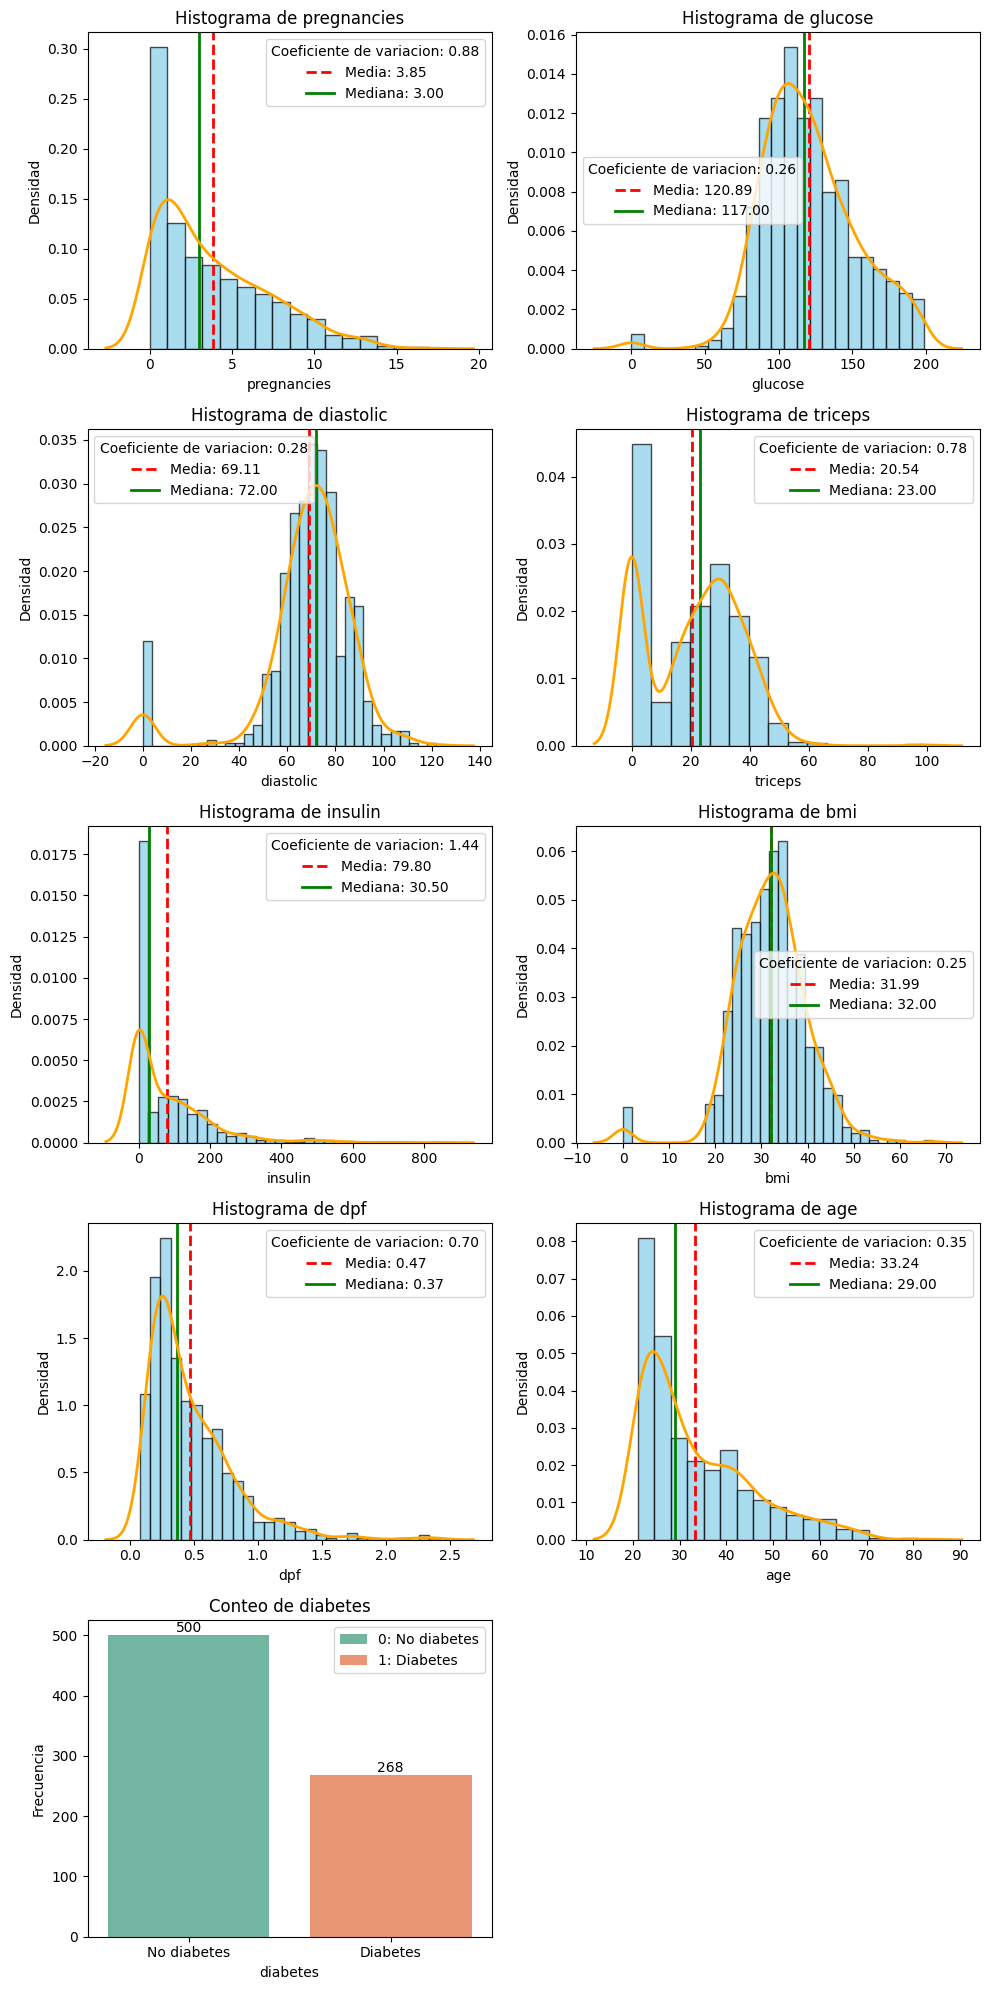

In [82]:
graficas_descriptivas(df)

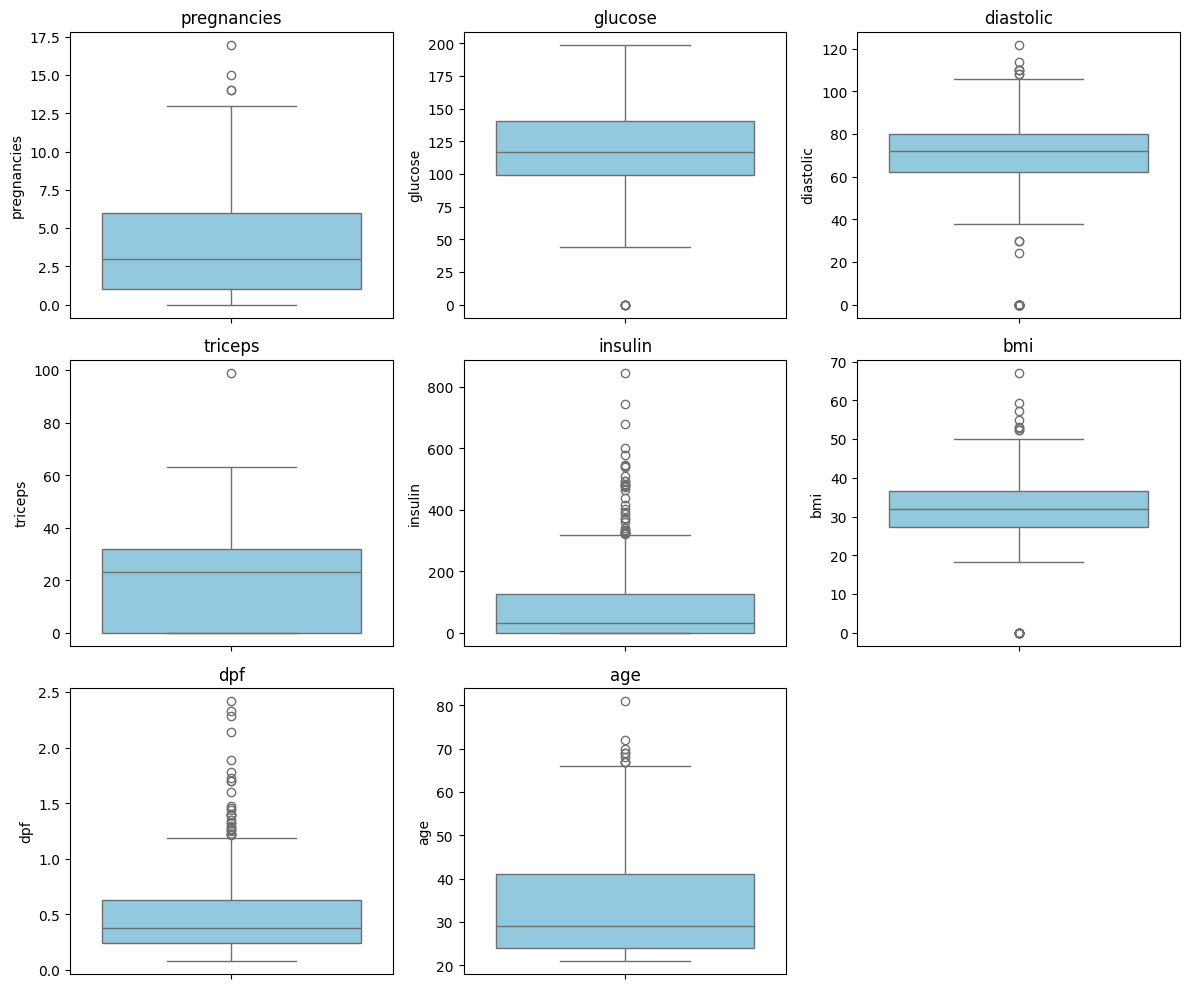

In [83]:
plt.figure(figsize=(12, 10))
for i, column in enumerate(df.columns[:-1], 1):
    plt.subplot(3, 3, i)
    sns.boxplot(y=df[column],color='skyblue')
    plt.title(column)

plt.tight_layout()
plt.show()

## Limpieza de datos

Note que algunas variables (__glucose__,__diastolic__ ,__triceps__ , __bmi__) parecen tener valores anormales.
Consultando con expertos, nos damos cuenta que es posible hallar valores 0 en las variables __glucose__ y __triceps__, sin embargo en las dos restantes pueden deberse a problemas en la medición (no existen presión arterial diastólica 0 en las personas, al igual que el IMC (BMI) pues para ello la persona tendria que pesar 0kg.

Revisemos a detalles la cantidad de datos anormales en estas dos columnas.

In [84]:
len(df[df['diastolic']<=40]), len(df[df['diastolic']==0])

(40, 35)

Para la columna __diastolic__ evidenciamos al menos 40 datos anormales: cuya presión diastólica es menor a 40 mmHg.

In [85]:
len(df[df['bmi']==0])

11

Para la columna __bmi__ evidenciamos 11 datos anormales: cuya IMC es igual a 0 kg/m2.

In [86]:
len(df[(df['diastolic'] <= 40) & (df['bmi'] == 0)])

7

Tenemos que hay 7 registros que parecen tener mediciones anormales en común en estas columnas.
Los registros eliminados serán aquellos que cumplan almenos una de las siguientes condiciones:
- Tengan __bmi__ = 0
- Tengan __diastolic__ <= 40

In [87]:
df_final = df.loc[(df['bmi'] > 0) & (df['diastolic'] > 40)]
df_final.shape

(724, 9)

Comparemos cuantos datos hemos eliminado

In [88]:
df.shape[0]- df_final.shape[0]
#Hemos eliminado 44 datos

44

Notemos este diagrama de dispersión que nos muestra algunos hechos interesantes entre la edad y el número de veces que ha estado en embarazo. Como se puede notar, bajo el contexto de la población, parecieran haber casos atipicos de valores altos de 'pregnancies' respecto a una baja edad 'age'.

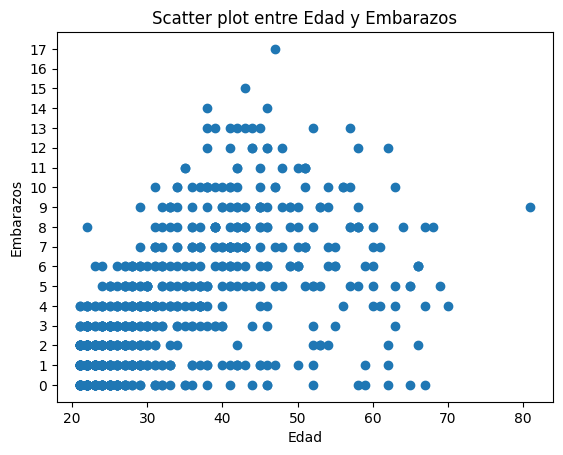

In [89]:
plt.scatter(df_final['age'], df_final['pregnancies'])
plt.xlabel('Edad')
plt.ylabel('Embarazos')
plt.title(f'Scatter plot entre Edad y Embarazos')

# Ajustar la escala del eje y a números enteros de 1 en 1
y_min = int(np.floor(df_final['pregnancies'].min()))
y_max = int(np.ceil(df_final['pregnancies'].max()))
plt.yticks(np.arange(y_min, y_max + 1, 1))
plt.show()

En este caso, no utilizaremos la columna 'pregnancies' al no tener totalmente una confirmación de estos datos atípicos.

In [90]:
df_final=df_final.drop('pregnancies', axis=1)
df_final.head()

,glucose,diastolic,triceps,insulin,bmi,dpf,age,diabetes
0,148.0,72,35.0,0.0,33.6,0.627,50,1
1,85.0,66,29.0,0.0,26.6,0.351,31,0
2,183.0,64,0.0,0.0,23.3,0.672,32,1
3,89.0,66,23.0,94.0,28.1,0.167,21,0
5,116.0,74,0.0,0.0,25.6,0.201,30,0


Veamos nuevamente los histogramas.

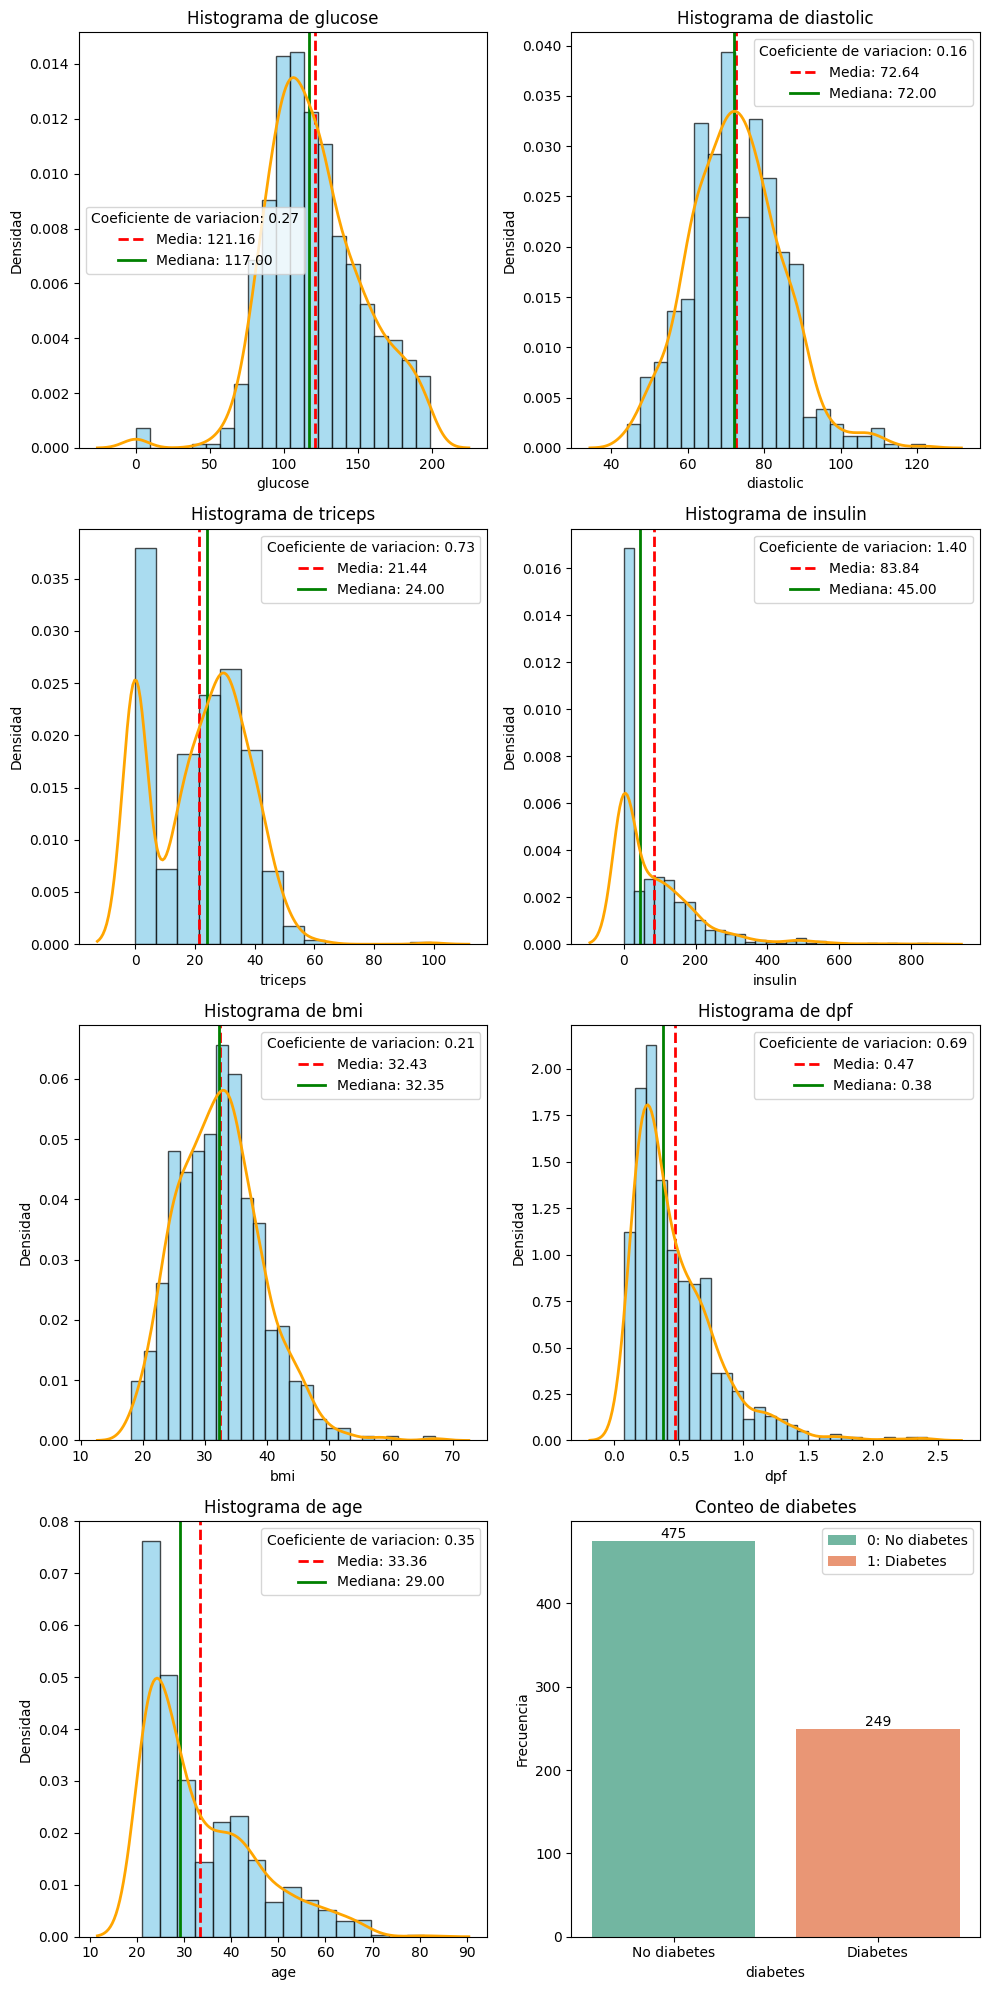

In [91]:
graficas_descriptivas(df_final)

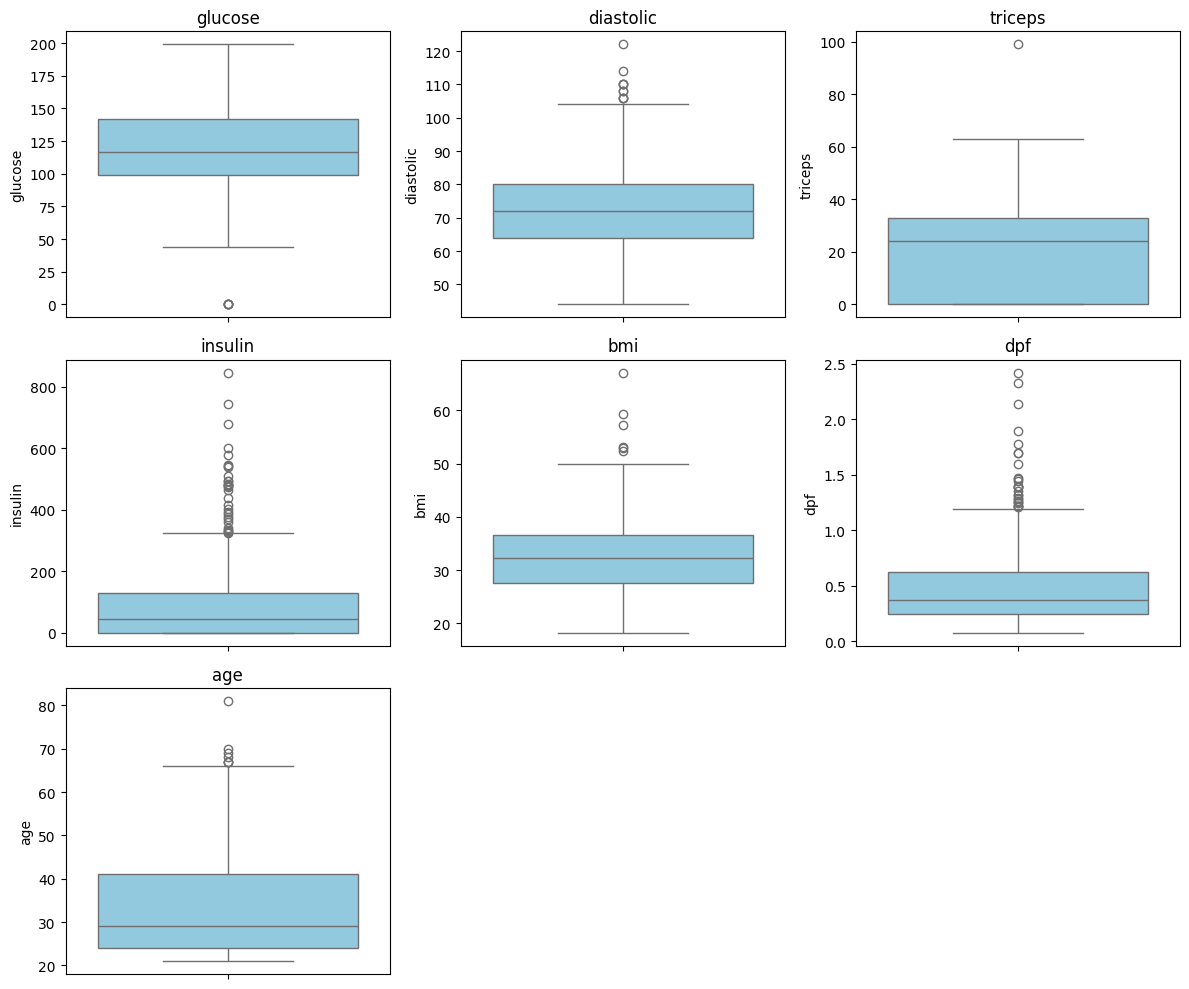

In [92]:
plt.figure(figsize=(12, 10))
for i, column in enumerate(df_final.columns[:-1], 1):
    plt.subplot(3, 3, i)
    sns.boxplot(y=df_final[column],color='skyblue')
    plt.title(column)

plt.tight_layout()
plt.show()

Realicemos una análisis de significancia (10%) respecto a las correlaciones entre variables explicativas para identificar problemas potenciales.

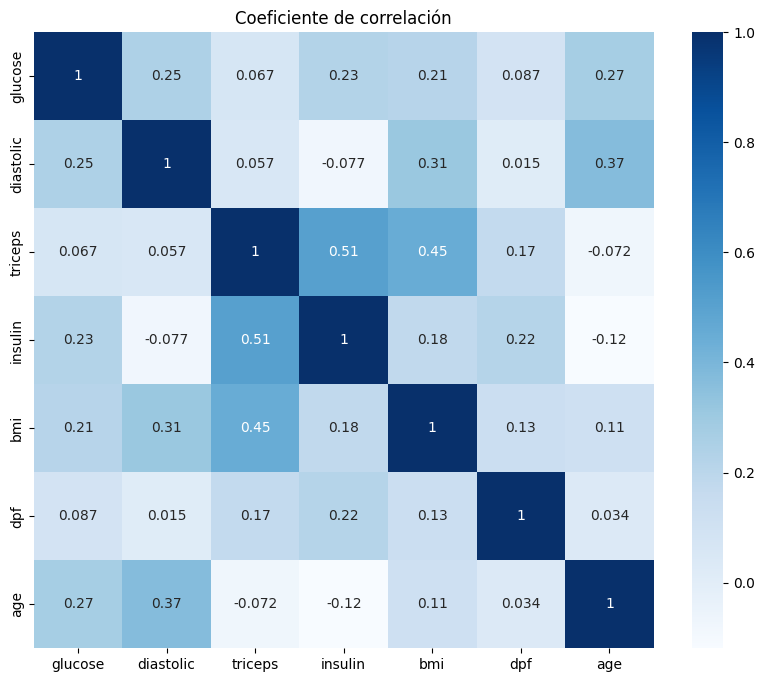

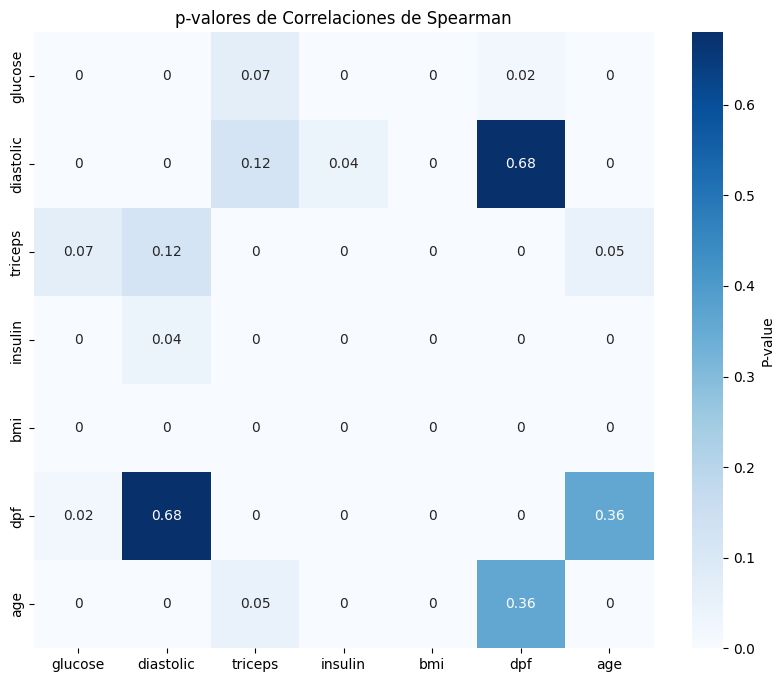

In [93]:
crear_mapa_calor(df_final.iloc[:,:-1], 'spearman')

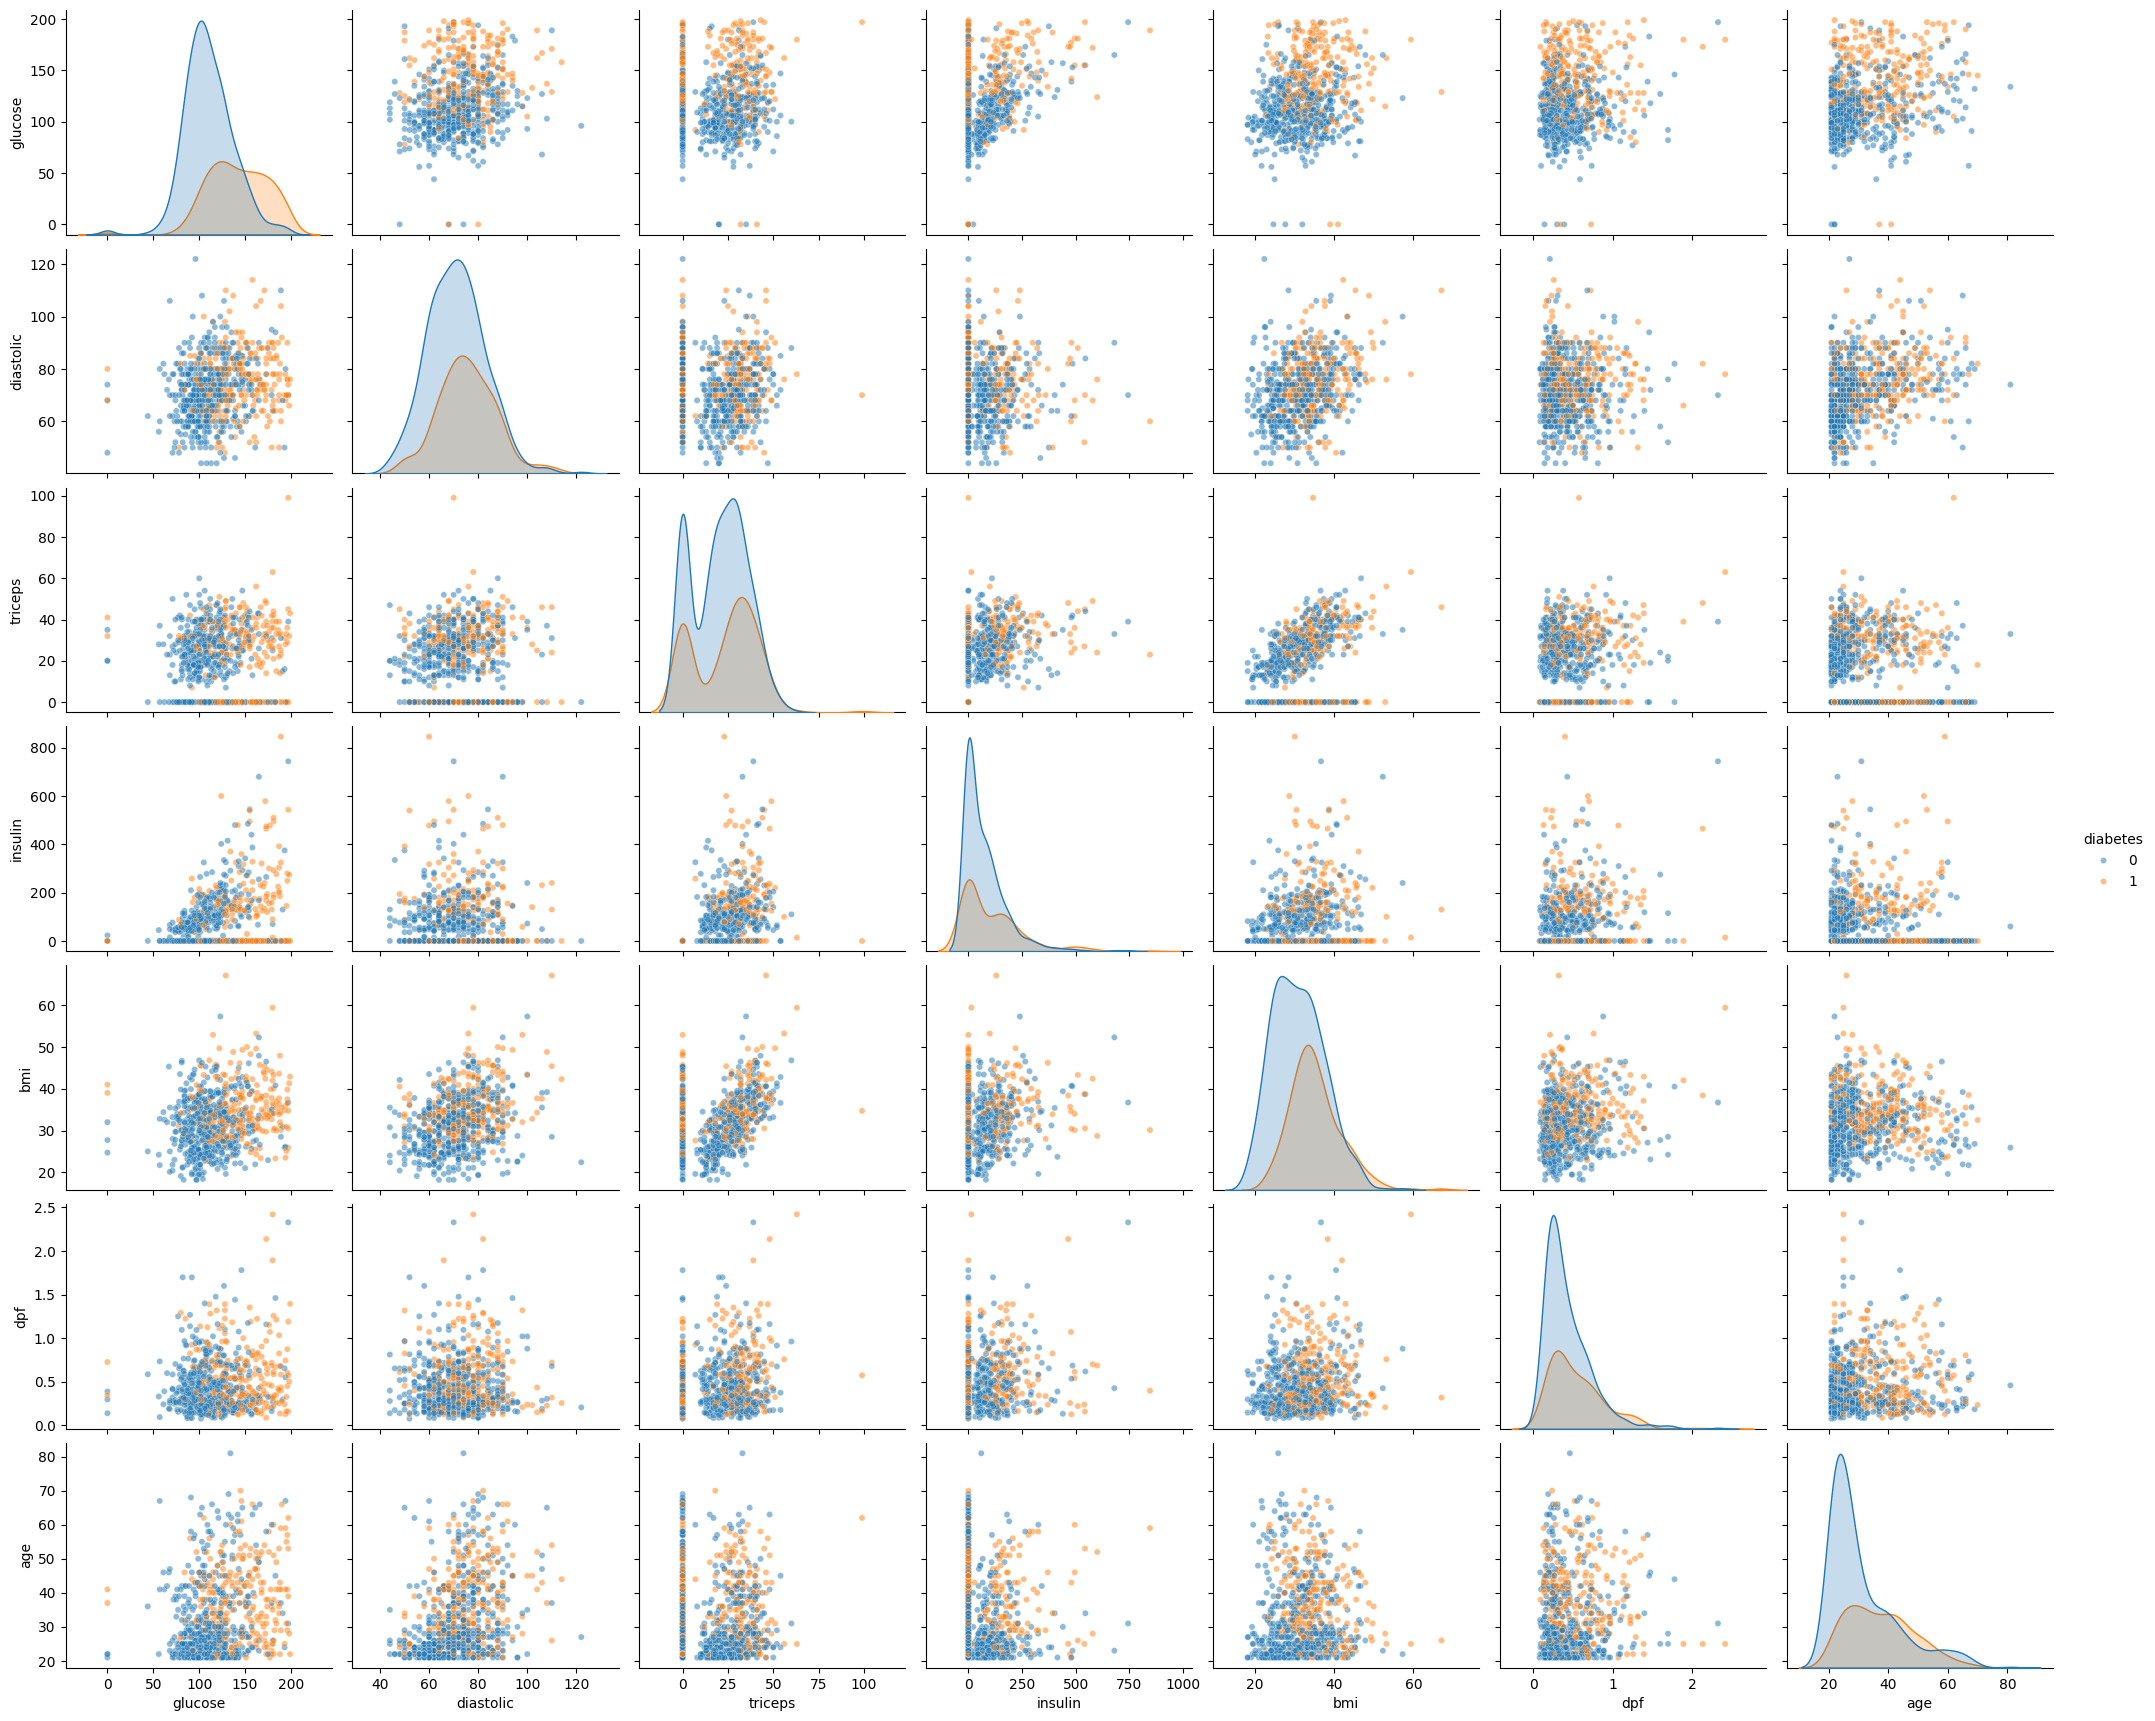

In [94]:
sns.pairplot(
    df_final,
    hue=df_final.columns[-1],  # Usar la última columna como categórica
    height=2.5,  # Tamaño de cada subgráfico
    aspect=1.2,  # Relación de aspecto
    plot_kws={'s': 20, 'alpha': 0.5}  # Tamaño de los puntos y transparencia
  )
# Mostrar la gráfica
plt.show()

Podemos ver que varios pares de variables que parecen tener correlación baja, pero significativa. Volveremos sobre ello mas adelante en caso de encontrar problemas en la calibración del modelo.

# Procesamiento de datos

In [95]:
df_final.head()

,glucose,diastolic,triceps,insulin,bmi,dpf,age,diabetes
0,148.0,72,35.0,0.0,33.6,0.627,50,1
1,85.0,66,29.0,0.0,26.6,0.351,31,0
2,183.0,64,0.0,0.0,23.3,0.672,32,1
3,89.0,66,23.0,94.0,28.1,0.167,21,0
5,116.0,74,0.0,0.0,25.6,0.201,30,0


## Variables dummy - OneHot Encoding
Clasificaremos el BMI (Indice de masa corporal) en las siguientes categorías de acuerdo a los lineamientos de la OMS:


In [96]:
#Categorizar la columna 'bmi'
df_final['bmi_category'] = pd.cut(
    df_final['bmi'],
    bins=[-float('inf'), 18.5, 25, 30, float('inf')],
    labels=['Bajo', 'Normal', 'Sobrepeso', 'Obesidad']
)

#Realizar One Hot Encoding
df_final = pd.get_dummies(df_final, columns=['bmi_category'])

#Eliminar la columna original 'bmi'
df_final.drop('bmi', axis=1, inplace=True)

print(df_final.head())

   glucose  diastolic  triceps  insulin    dpf  age  diabetes  \
0    148.0         72     35.0      0.0  0.627   50         1   
1     85.0         66     29.0      0.0  0.351   31         0   
2    183.0         64      0.0      0.0  0.672   32         1   
3     89.0         66     23.0     94.0  0.167   21         0   
5    116.0         74      0.0      0.0  0.201   30         0   

   bmi_category_Bajo  bmi_category_Normal  bmi_category_Sobrepeso  \
0              False                False                   False   
1              False                False                    True   
2              False                 True                   False   
3              False                False                    True   
5              False                False                    True   

   bmi_category_Obesidad  
0                   True  
1                  False  
2                  False  
3                  False  
5                  False  


## División de datos para entrenamiento, validación y prueba

In [97]:
# Dividimos el conjunto de datos
train_set, val_set, test_set = train_val_test_split(df_final, stratify='diabetes')

X_train, y_train = remove_labels(train_set, 'diabetes')
X_val, y_val = remove_labels(val_set, 'diabetes')
X_test, y_test = remove_labels(test_set, 'diabetes')
x_names=np.array(X_train.columns)

In [98]:
print(f"Dimensiones conjuntos de entrenamiento: {X_train.shape}, {y_train.shape}")
print(f"Dimensiones conjuntos de validacion: {X_val.shape}, {y_val.shape}")
print(f"Dimensiones conjuntos de test: {X_test.shape}, {y_test.shape}")

Dimensiones conjuntos de entrenamiento: (506, 10), (506,)
Dimensiones conjuntos de validacion: (109, 10), (109,)
Dimensiones conjuntos de test: (109, 10), (109,)


## Balanceo de datos

Realizamos con el balanceo via Oversampling

In [99]:
conteo_prebal(y_train)

Cantidad de etiquetas '0': 332, (65.61%)
Cantidad de etiquetas '1': 174, (34.39%)


In [100]:
os = SVMSMOTE(random_state=42)
X_train, y_train= os.fit_resample(X_train, y_train)

In [101]:
conteo_prebal(y_train)

Cantidad de etiquetas '0': 332, (50.0%)
Cantidad de etiquetas '1': 332, (50.0%)


## Escalado de Caracteristicas

In [102]:
scaler = MinMaxScaler()

transformer_train = scaler.fit_transform(X_train)
transformer_val = scaler.fit_transform(X_val)
transformer_test = scaler.fit_transform(X_test)

X_train = pd.DataFrame(transformer_train)
X_val = pd.DataFrame(transformer_val)
X_test = pd.DataFrame(transformer_test)


In [103]:
X_train.columns = x_names
X_val.columns = x_names
X_test.columns = x_names

In [104]:
X_train

,glucose,diastolic,triceps,insulin,dpf,age,bmi_category_Bajo,bmi_category_Normal,bmi_category_Sobrepeso,bmi_category_Obesidad
0,0.572864,0.390244,0.171717,0.119223,0.202222,0.303571,0.0,1.0,0.0,0.0
1,0.628141,0.634146,0.000000,0.000000,0.118933,0.125000,0.0,1.0,0.0,0.0
2,0.618090,0.536585,0.373737,0.000000,0.092394,0.267857,0.0,0.0,0.0,1.0
3,0.542714,0.219512,0.242424,0.000000,0.103010,0.196429,0.0,0.0,1.0,0.0
4,0.688442,0.207317,0.000000,0.000000,0.073613,0.732143,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
659,0.860516,0.292683,0.505999,0.635209,0.301564,0.196429,0.0,0.0,0.0,1.0
660,0.826241,0.329268,0.427400,0.122136,0.351110,0.571429,0.0,0.0,0.0,1.0
661,0.678277,0.500000,0.470986,0.351344,0.248498,0.892857,0.0,0.0,0.0,1.0
662,0.937621,0.426829,0.000000,0.000000,0.052152,0.553571,0.0,0.0,0.0,1.0


## Seleccion de características

Escojamos las mejores características utilizando SelectKBest

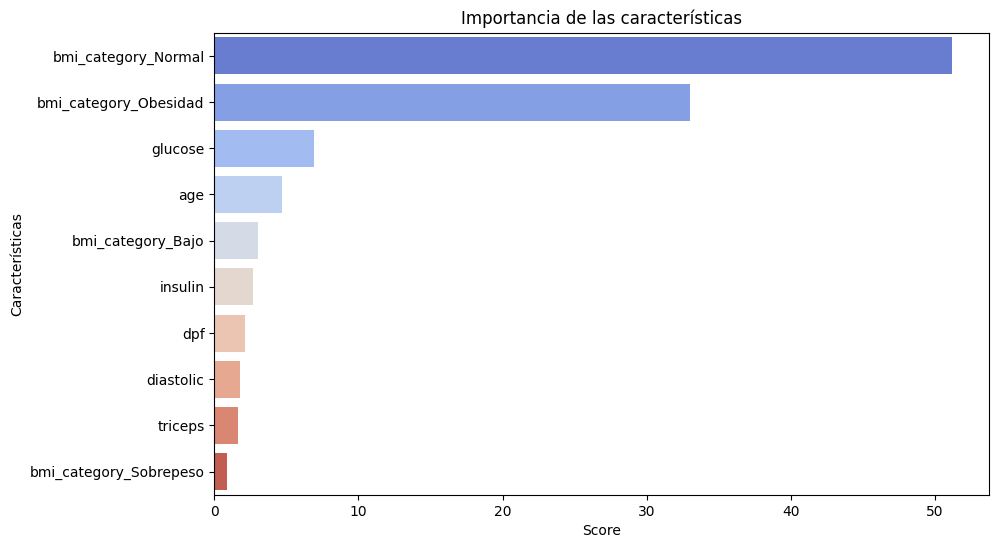

In [105]:
import pandas as pd
from sklearn.feature_selection import SelectKBest, chi2

# Extrae los nombres de las columnas
feature_names = x_names

# Selecciona las mejores características con SelectKBest
k_best = SelectKBest(score_func=chi2, k='all')

# Ajusta el selector a los datos
k_best.fit(X_train, y_train)

# Obtener los índices de las características seleccionadas
selected_features = k_best.get_support(indices=True)

# Obtener los scores
scores = k_best.scores_

# Crear un DataFrame con los scores y los nombres de las características
features_scores = pd.DataFrame({
    'Feature': feature_names,
    'Score': scores
})

# Filtrar solo las características seleccionadas
features_scores = features_scores.loc[selected_features]

# Ordenar por score de mayor a menor
features_scores_graph = features_scores.sort_values(by='Score', ascending=False)

# Graficar
plt.figure(figsize=(10, 6))
sns.barplot(x='Score', y='Feature', data=features_scores_graph, palette='coolwarm')
plt.title('Importancia de las características')
plt.xlabel('Score')
plt.ylabel('Características')
plt.show()

Seleccionemos las primeras 6 características (mayor score)

In [106]:
caracteristicas=features_scores_graph.head(6)['Feature'].tolist()

In [107]:
caracteristicas

['bmi_category_Normal',
 'bmi_category_Obesidad',
 'glucose',
 'age',
 'bmi_category_Bajo',
 'insulin']

In [108]:
X_train = X_train[caracteristicas]
X_val = X_val[caracteristicas]
X_test = X_test[caracteristicas]

In [109]:
X_train

,bmi_category_Normal,bmi_category_Obesidad,glucose,age,bmi_category_Bajo,insulin
0,1.0,0.0,0.572864,0.303571,0.0,0.119223
1,1.0,0.0,0.628141,0.125000,0.0,0.000000
2,0.0,1.0,0.618090,0.267857,0.0,0.000000
3,0.0,0.0,0.542714,0.196429,0.0,0.000000
4,1.0,0.0,0.688442,0.732143,0.0,0.000000
...,...,...,...,...,...,...
659,0.0,1.0,0.860516,0.196429,0.0,0.635209
660,0.0,1.0,0.826241,0.571429,0.0,0.122136
661,0.0,1.0,0.678277,0.892857,0.0,0.351344
662,0.0,1.0,0.937621,0.553571,0.0,0.000000


# Entrenamiento de los modelos y Validación

Una vez seleccionadas las características, procedemos con el entrenamiento de los modelos, para ello, utilizaremos Random_Search para encontrar los mejores hiperparámetros de cada modelo, y usando la metrica accuracy-score, calibraremos y escogeremos el mejor modelo.

La razón por la cual escojemos la metrica accuracy, es para poder controlar correctamente los verdaderos negativos como los verdaderos positivos, es decir, buscar siempre el diagnóstico correcto.

## Busqueda de hiperparámetros y Selección del mejor modelo

In [110]:
models.keys()

dict_keys(['KNeighbors', 'LogisticRegression', 'DecisionTree', 'RandomForest', 'SVC', 'GaussianNB', 'Gradient Boosting'])

In [111]:
best_model, scoring, score_train, score_val  = train_and_evaluate_models(models, X_train, y_train, X_val, y_val, scoring='accuracy', n_iter=50, cv=5)

Entrenando: KNeighbors
Mejores hiperparámetros para KNeighbors: {'weights': 'distance', 'n_neighbors': 11, 'leaf_size': 30, 'algorithm': 'ball_tree'}
Mejor accuracy-score: 0.7967304625199362

Entrenando: LogisticRegression
Mejores hiperparámetros para LogisticRegression: {'solver': 'lbfgs', 'penalty': 'l2', 'max_iter': 300, 'C': 10}
Mejor accuracy-score: 0.7711779448621555

Entrenando: DecisionTree
Mejores hiperparámetros para DecisionTree: {'min_samples_split': 100, 'min_samples_leaf': 2, 'max_depth': 8, 'criterion': 'gini'}
Mejor accuracy-score: 0.7967988152198677

Entrenando: RandomForest
Mejores hiperparámetros para RandomForest: {'n_estimators': 124, 'min_samples_split': 10, 'max_features': 'log2', 'max_depth': 6, 'criterion': 'gini', 'bootstrap': True}
Mejor accuracy-score: 0.7997835497835497

Entrenando: SVC
Mejores hiperparámetros para SVC: {'kernel': 'rbf', 'gamma': 10, 'degree': 2, 'C': 10}
Mejor accuracy-score: 0.7832080200501254

Entrenando: GaussianNB
Mejores hiperparámetr

# Validación del modelo escogido

In [112]:
print(f"{scoring}-score en el conjunto de entrenamiento: {score_train}")
print(f"{scoring}-score en el conjunto de validación: {score_val}")

accuracy-score en el conjunto de entrenamiento: 0.8524096385542169
accuracy-score en el conjunto de validación: 0.7981651376146789


## Matrices de confusión

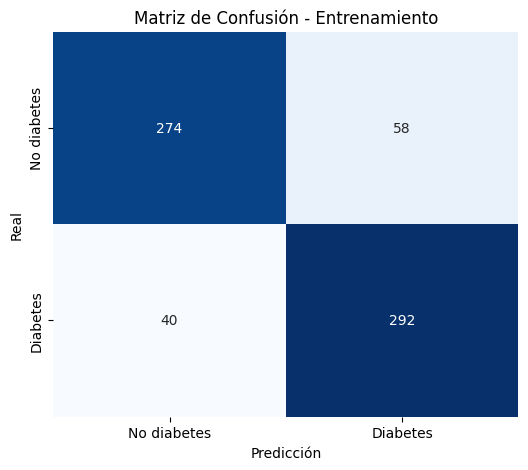

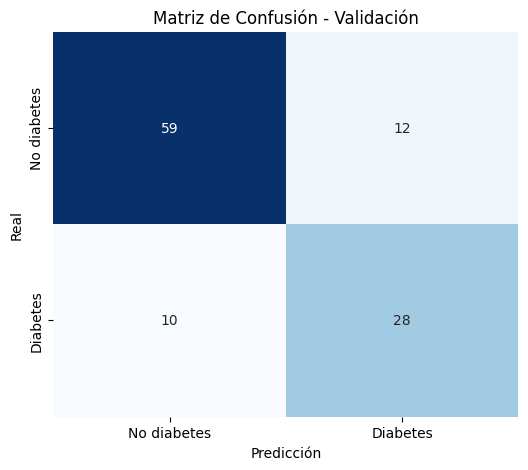

In [113]:
# Calcular las matrices de confusión
cm_train = confusion_matrix(y_train, best_model.predict(X_train))
cm_val = confusion_matrix(y_val, best_model.predict(X_val))
cm_test= confusion_matrix(y_test, best_model.predict(X_test))

# Función para graficar la matriz de confusión
def plot_confusion_matrix(cm, title='Matriz de Confusión'):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['No diabetes', 'Diabetes'],
                yticklabels=['No diabetes', 'Diabetes'])
    plt.title(title)
    plt.xlabel('Predicción')
    plt.ylabel('Real')
    plt.show()

# Graficar las matrices de confusión
plot_confusion_matrix(cm_train, title='Matriz de Confusión - Entrenamiento')
plot_confusion_matrix(cm_val, title='Matriz de Confusión - Validación')


## Cross Validation

In [114]:
from sklearn.model_selection import ShuffleSplit

In [115]:
z = cross_val_score(best_model, X_train, y_train, cv = ShuffleSplit(n_splits=10, test_size=0.2), scoring=scoring)
print (z)
print(f"{scoring} score  {np.mean(z):.3f} (±{np.std(z):.4f})")

[0.80451128 0.84962406 0.7443609  0.78195489 0.84962406 0.78947368
 0.81954887 0.79699248 0.78947368 0.78195489]
accuracy score  0.801 (±0.0305)


## Boostraping

In [116]:
(trmean, trstd), (tsmean, tsstd) = bootstrap_score(best_model, X_train, y_train, test_size=0.3, scoring=scoring)
print ("train score %.3f (±%.4f)"%(trmean, trstd))
print ("val score  %.3f (±%.4f)"%(tsmean, tsstd))

train score 0.861 (±0.0123)
val score  0.802 (±0.0229)


# Rendimiento

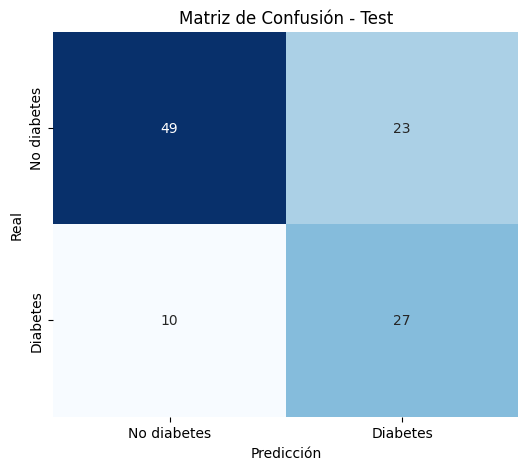

In [117]:
cm_test = confusion_matrix(y_test, best_model.predict(X_test))
plot_confusion_matrix(cm_test, title='Matriz de Confusión - Test')

In [118]:
final_score = get_metric_score(y_test,best_model.predict(X_test), scoring)
print(f"{scoring}-score: {final_score:.2f}")

accuracy-score: 0.70


In [119]:
print(f"{scoring}-score en el conjunto de entrenamiento: {get_metric_score(y_train,best_model.predict(X_train), scoring)}")
print(f"{scoring}-score en el conjunto de test: {final_score}")

print("Validacion cruzada: %.3f (±%.4f)"%(trmean, trstd))

accuracy-score en el conjunto de entrenamiento: 0.8418674698795181
accuracy-score en el conjunto de test: 0.6972477064220184
Validacion cruzada: 0.861 (±0.0123)


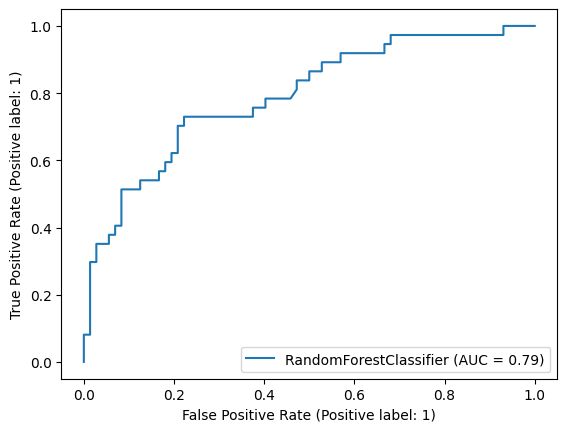

In [120]:
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_estimator(best_model, X_test, y_test)

In [121]:
from sklearn.metrics import classification_report
print(classification_report(y_test, best_model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.83      0.68      0.75        72
           1       0.54      0.73      0.62        37

    accuracy                           0.70       109
   macro avg       0.69      0.71      0.68       109
weighted avg       0.73      0.70      0.70       109



# Calibración 1: Reducción de dimensionalidad
A continuación, repetimos el proceso anterior entrenando los modelos haciendo una transformación en los datos.

## División de datos para entrenamiento, validación y prueba

In [122]:
# Dividimos el conjunto de datos
train_set, val_set, test_set = train_val_test_split(df_final, stratify='diabetes')

X_train, y_train = remove_labels(train_set, 'diabetes')
X_val, y_val = remove_labels(val_set, 'diabetes')
X_test, y_test = remove_labels(test_set, 'diabetes')

In [123]:
print(f"Dimensiones conjuntos de entrenamiento: {X_train.shape}, {y_train.shape}")
print(f"Dimensiones conjuntos de validacion: {X_val.shape}, {y_val.shape}")
print(f"Dimensiones conjuntos de test: {X_test.shape}, {y_test.shape}")


Dimensiones conjuntos de entrenamiento: (506, 10), (506,)
Dimensiones conjuntos de validacion: (109, 10), (109,)
Dimensiones conjuntos de test: (109, 10), (109,)


## Balanceo de datos

Realizamos con el balanceo via Oversampling

In [124]:
conteo_prebal(y_train)

Cantidad de etiquetas '0': 332, (65.61%)
Cantidad de etiquetas '1': 174, (34.39%)


In [125]:
os = SVMSMOTE(random_state=42)
X_train, y_train= os.fit_resample(X_train, y_train)

In [126]:
conteo_prebal(y_train)

Cantidad de etiquetas '0': 332, (50.0%)
Cantidad de etiquetas '1': 332, (50.0%)


## Análisis PCA

In [127]:
# Recordemos que ya tenemos la división en 3 subconjuntos de la información
X_train.head()

,glucose,diastolic,triceps,insulin,dpf,age,bmi_category_Bajo,bmi_category_Normal,bmi_category_Sobrepeso,bmi_category_Obesidad
0,114.0,76,17.0,110.0,0.466,31,False,True,False,False
1,125.0,96,0.0,0.0,0.262,21,False,True,False,False
2,123.0,88,37.0,0.0,0.197,29,False,False,False,True
3,108.0,62,24.0,0.0,0.223,25,False,False,True,False
4,137.0,61,0.0,0.0,0.151,55,False,True,False,False


In [128]:
from sklearn.decomposition import PCA

def aplicar_pca(data, n_componentes):
    escalador = MinMaxScaler()
    data_escalada = escalador.fit_transform(data)
    pca = PCA(n_components=n_componentes)
    componentes_principales = pca.fit_transform(data_escalada)
    varianza_explicada = pca.explained_variance_ratio_

    # Crear un DataFrame para los componentes principales
    df_componentes = pd.DataFrame(data=componentes_principales, columns=[f'PC{i+1}' for i in range(n_componentes)])

    # Crear DataFrame para la varianza explicada y acumulada
    df_varianza = pd.DataFrame({
        'Componente Principal': [f'PC{i+1}' for i in range(n_componentes)],
        'Varianza Explicada': varianza_explicada,
        'Varianza Acumulada': varianza_explicada.cumsum()
    })

    # Ordenar el DataFrame por varianza explicada en orden ascendente
    df_varianza = df_varianza.sort_values(by='Varianza Explicada', ascending=False).reset_index(drop=True)

    return df_componentes, df_varianza, pca, escalador

DataFrame con la varianza explicada y acumulada por cada componente principal:
  Componente Principal  Varianza Explicada  Varianza Acumulada
0                  PC1            0.486820            0.486820
1                  PC2            0.254864            0.741685
2                  PC3            0.072708            0.814392
3                  PC4            0.054964            0.869357
4                  PC5            0.031816            0.901172
5                  PC6            0.028604            0.929776
6                  PC7            0.026452            0.956228
7                  PC8            0.022847            0.979076
8                  PC9            0.014801            0.993877
9                 PC10            0.006123            1.000000


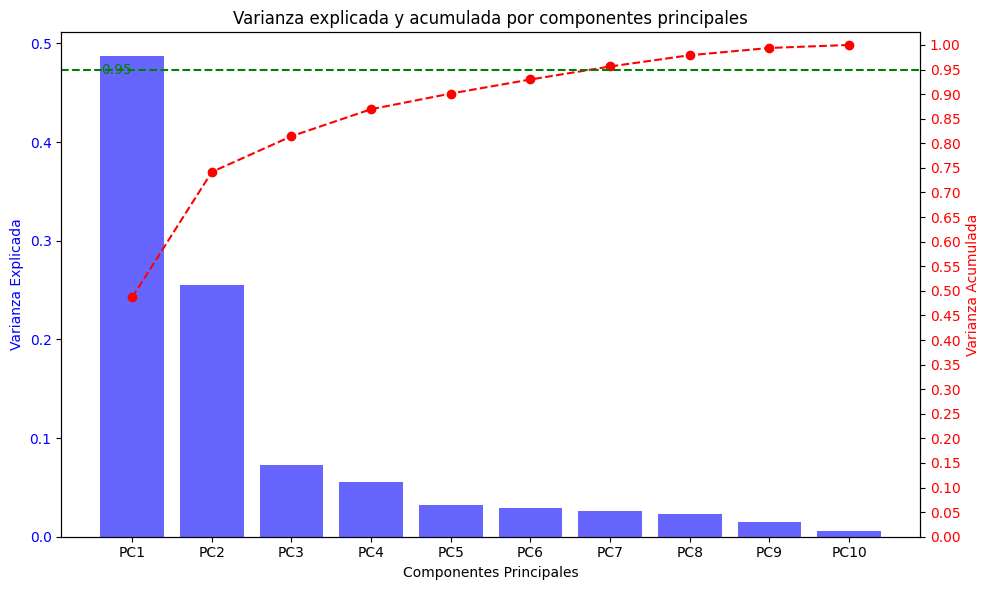

In [129]:
df_componentes, df_varianza, pca, escalador = aplicar_pca(X_train, n_componentes=10)

# Mostrar la varianza explicada por cada componente principal
print('DataFrame con la varianza explicada y acumulada por cada componente principal:')
print(df_varianza)

# Graficar la varianza explicada y la varianza acumulada
fig, ax1 = plt.subplots(figsize=(10, 6))

# Barras para la varianza explicada
ax1.bar(df_varianza['Componente Principal'], df_varianza['Varianza Explicada'], color='b', alpha=0.6)
ax1.set_xlabel('Componentes Principales')
ax1.set_ylabel('Varianza Explicada', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Línea para la varianza acumulada
ax2 = ax1.twinx()
ax2.plot(df_varianza['Componente Principal'], df_varianza['Varianza Acumulada'], color='r', marker='o', linestyle='--')
ax2.set_ylabel('Varianza Acumulada', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Dibujar una línea horizontal en el valor 0.95
ax2.axhline(y=0.95, color='g', linestyle='--')
ax2.text(0, 0.95, '0.95', color='g', va='center', ha='right')

# Establecer los ticks del eje y del segundo eje en incrementos de 0.01
ax2.set_yticks(np.arange(0, 1.05, 0.05))

plt.title('Varianza explicada y acumulada por componentes principales')
fig.tight_layout()
plt.show()



Seleccionamos las componentes cuya varianza explicada acumulada es hasta 95%, es decir, las primeras 6 componentes

In [130]:
# Transformar X_train
def transformar_conjunto(data, escalador, pca, n_componentes):
    data_escalada = escalador.transform(data)
    data_pca = pca.transform(data_escalada)
    return pd.DataFrame(data=data_pca[:, :n_componentes], columns=[f'PC{i+1}' for i in range(n_componentes)])

In [131]:
X_train_pca = transformar_conjunto(X_train, escalador, pca, n_componentes=6)
X_val_pca = transformar_conjunto(X_val, escalador, pca, n_componentes=6)
X_test_pca = transformar_conjunto(X_test, escalador, pca, n_componentes=6)

In [132]:
# Mostrar un resumen de los datos transformados
print(X_train_pca.head())
print(X_val_pca.head())
print(X_test_pca.head())

        PC1       PC2       PC3       PC4       PC5       PC6
0  0.603048  0.967394 -0.001854  0.142144 -0.041187 -0.041214
1  0.609952  0.986017 -0.007402 -0.020089  0.147872 -0.223632
2 -0.408542 -0.012021 -0.063555 -0.074835  0.095542  0.044114
3  0.979692 -0.375743 -0.166399 -0.067069  0.071789  0.018236
4  0.615806  0.977956  0.413241  0.050549 -0.074878 -0.061259
        PC1       PC2       PC3       PC4       PC5       PC6
0 -0.450219 -0.049218  0.309657  0.318100  0.025513  0.021635
1 -0.395898 -0.007529  0.039793 -0.109633 -0.031065  0.210671
2  0.985108 -0.371887 -0.077320 -0.078204 -0.009781  0.183869
3  0.946801 -0.394687  0.121940  0.085779  0.117526  0.098401
4 -0.403266 -0.010933 -0.062290 -0.016940  0.097439 -0.181032
        PC1       PC2       PC3       PC4       PC5       PC6
0 -0.406481 -0.013513 -0.144258 -0.014513  0.054981 -0.000207
1  0.599097  0.962726  0.096081  0.181458  0.038119 -0.296632
2 -0.424468 -0.027756 -0.187869  0.183086  0.062204 -0.064541
3  0.950

## Entrenamiento de los modelos

Una vez seleccionadas las características, procedemos con el entrenamiento de los modelos, para ello, utilizaremos Random_Search para encontrar los mejores hiperparámetros de cada modelo, y usando la metrica RECALL=True Positive/(True positive + False Negative), calibraremos y escogeremos el mejor modelo.

La razón por la cual escojemos la metrica RECALL, es para poder controlar correctamente los falsos negativos, es decir, pacientes propensos a desarrollar diabetes pero que el modelo los clasifica como no propensos a desarrollar diabetes, con esto tenemos mas chances de predecir un diagnóstico correcto y poder hablar de medicina preventiva.

### Busqueda de hiperparámetros y Selección del mejor modelo

In [133]:
best_model_1, scoring_1, score_train_1, score_val_1  = train_and_evaluate_models(models, X_train_pca, y_train, X_val_pca, y_val, scoring='accuracy', n_iter=50, cv=5)

Entrenando: KNeighbors
Mejores hiperparámetros para KNeighbors: {'weights': 'distance', 'n_neighbors': 11, 'leaf_size': 30, 'algorithm': 'ball_tree'}
Mejor accuracy-score: 0.8118136249715198

Entrenando: LogisticRegression
Mejores hiperparámetros para LogisticRegression: {'solver': 'lbfgs', 'penalty': 'l2', 'max_iter': 300, 'C': 10}
Mejor accuracy-score: 0.7787195260879473

Entrenando: DecisionTree
Mejores hiperparámetros para DecisionTree: {'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': 7, 'criterion': 'log_loss'}
Mejor accuracy-score: 0.7621326042378673

Entrenando: RandomForest
Mejores hiperparámetros para RandomForest: {'n_estimators': 124, 'min_samples_split': 10, 'max_features': 'log2', 'max_depth': 6, 'criterion': 'gini', 'bootstrap': True}
Mejor accuracy-score: 0.7922761449077238

Entrenando: SVC
Mejores hiperparámetros para SVC: {'kernel': 'rbf', 'gamma': 10, 'degree': 2, 'C': 10}
Mejor accuracy-score: 0.7937571200729095

Entrenando: GaussianNB
Mejores hiperparám

## Validación del modelo escogido

In [134]:
print(f"{scoring_1}-score en el conjunto de entrenamiento: {score_train_1}")
print(f"{scoring_1}-score en el conjunto de validación: {score_val_1}")

accuracy-score en el conjunto de entrenamiento: 0.7816265060240963
accuracy-score en el conjunto de validación: 0.7706422018348624


### Matrices de confusión

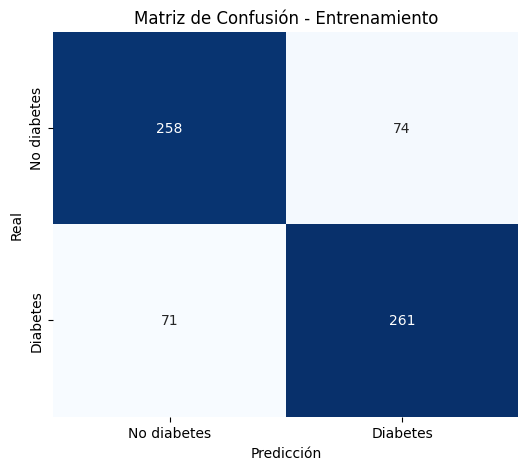

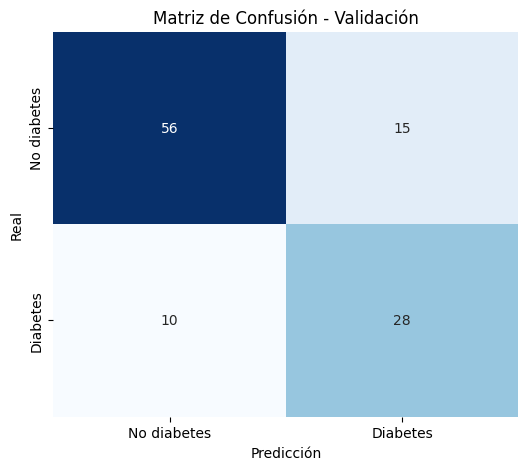

In [135]:
# Calcular las matrices de confusión
cm_train = confusion_matrix(y_train, best_model_1.predict(X_train_pca))
cm_val = confusion_matrix(y_val, best_model_1.predict(X_val_pca))

# Función para graficar la matriz de confusión
def plot_confusion_matrix(cm, title='Matriz de Confusión'):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['No diabetes', 'Diabetes'],
                yticklabels=['No diabetes', 'Diabetes'])
    plt.title(title)
    plt.xlabel('Predicción')
    plt.ylabel('Real')
    plt.show()

# Graficar las matrices de confusión
plot_confusion_matrix(cm_train, title='Matriz de Confusión - Entrenamiento')
plot_confusion_matrix(cm_val, title='Matriz de Confusión - Validación')

### Cross Validation

In [136]:
z_1 = cross_val_score(best_model_1, X_train_pca, y_train, cv = ShuffleSplit(n_splits=10, test_size=0.3),scoring=scoring_1)
print (z_1)
print(f"{scoring} score  {np.mean(z):.3f} (±{np.std(z):.4f})")

[0.78  0.795 0.755 0.775 0.775 0.81  0.755 0.755 0.795 0.785]
accuracy score  0.801 (±0.0305)


### Boostraping

In [137]:
(trmean_1, trstd_1), (tsmean_1, tsstd_1) = bootstrap_score(best_model_1, X_train_pca, y_train, test_size=0.3, scoring=scoring_1)
print ("train score %.3f (±%.4f)"%(trmean_1, trstd_1))
print ("test score  %.3f (±%.4f)"%(tsmean_1, tsstd_1))

train score 0.787 (±0.0172)
test score  0.780 (±0.0292)


## Rendimiento

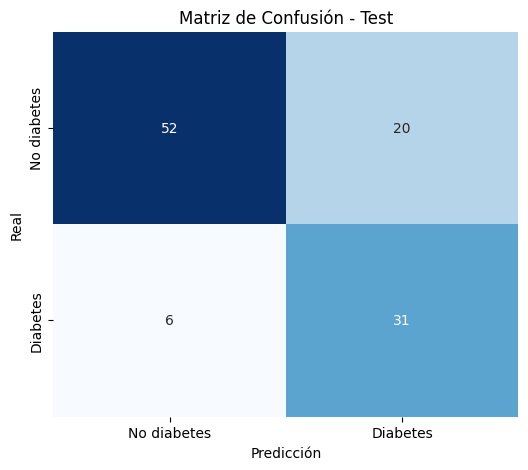

In [138]:
cm_test = confusion_matrix(y_test, best_model_1.predict(X_test_pca))
plot_confusion_matrix(cm_test, title='Matriz de Confusión - Test')

In [139]:
final_score_1 = get_metric_score(y_test,best_model_1.predict(X_test_pca), scoring=scoring_1)
print(f"{scoring_1}-score: {final_score_1:.2f}")

accuracy-score: 0.76


In [140]:
print(f"{scoring_1}-score en el conjunto de entrenamiento: {get_metric_score(y_train,best_model_1.predict(X_train_pca), scoring=scoring_1)}")
print(f"{scoring_1}-score en el conjunto de test: {final_score_1}")

print("Validacion cruzada: %.3f (±%.4f)"%(trmean_1, trstd_1))

accuracy-score en el conjunto de entrenamiento: 0.7801204819277109
accuracy-score en el conjunto de test: 0.7614678899082569
Validacion cruzada: 0.787 (±0.0172)


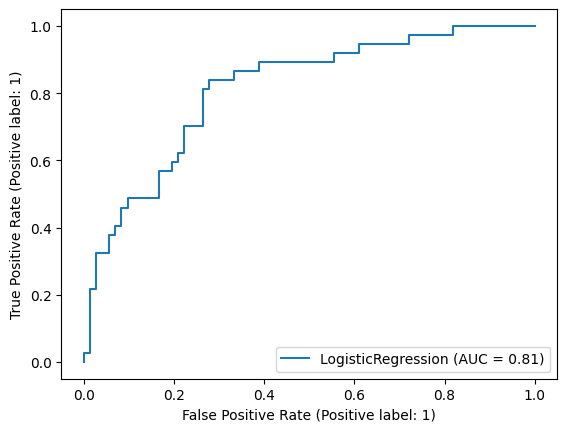

In [141]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_estimator(best_model_1, X_test_pca, y_test)

# Calibración 2: Priorizando el recall

A continuación, repetimos el proceso anterior entrenando los modelos bajo la métrica 'Recall' priorizando reducir los falsos negativos.

Una vez seleccionadas las características, procedemos con el entrenamiento de los modelos, para ello, utilizaremos Random_Search para encontrar los mejores hiperparámetros de cada modelo, y usando la metrica RECALL=True Positive/(True positive + False Negative), calibraremos y escogeremos el mejor modelo.

La razón por la cual escojemos la metrica RECALL, es para poder controlar correctamente los falsos negativos, es decir, pacientes propensos a desarrollar diabetes pero que el modelo los clasifica como no propensos a desarrollar diabetes, con esto tenemos mas chances de predecir un diagnóstico correcto y poder hablar de medicina preventiva.

## División de datos para entrenamiento, validación y prueba

In [142]:
# Dividimos el conjunto de datos
train_set, val_set, test_set = train_val_test_split(df_final, stratify='diabetes')

X_train, y_train = remove_labels(train_set, 'diabetes')
X_val, y_val = remove_labels(val_set, 'diabetes')
X_test, y_test = remove_labels(test_set, 'diabetes')

In [143]:
print(f"Dimensiones conjuntos de entrenamiento: {X_train.shape}, {y_train.shape}")
print(f"Dimensiones conjuntos de validacion: {X_val.shape}, {y_val.shape}")
print(f"Dimensiones conjuntos de test: {X_test.shape}, {y_test.shape}")


Dimensiones conjuntos de entrenamiento: (506, 10), (506,)
Dimensiones conjuntos de validacion: (109, 10), (109,)
Dimensiones conjuntos de test: (109, 10), (109,)


## Balanceo de datos

Realizamos con el balanceo via Oversampling

In [144]:
conteo_prebal(y_train)

Cantidad de etiquetas '0': 332, (65.61%)
Cantidad de etiquetas '1': 174, (34.39%)


In [145]:
os = SVMSMOTE(random_state=42)
X_train, y_train= os.fit_resample(X_train, y_train)

In [146]:
conteo_prebal(y_train)

Cantidad de etiquetas '0': 332, (50.0%)
Cantidad de etiquetas '1': 332, (50.0%)


## Escalado de Caracteristicas

In [147]:
scaler = MinMaxScaler()

transformer_train = scaler.fit_transform(X_train)
transformer_val = scaler.fit_transform(X_val)
transformer_test = scaler.fit_transform(X_test)

X_train = pd.DataFrame(transformer_train)
X_val = pd.DataFrame(transformer_val)
X_test = pd.DataFrame(transformer_test)


In [148]:
X_train.columns = x_names
X_val.columns = x_names
X_test.columns = x_names

## Seleccion de características

Escojamos las mejores características utilizando SelectKBest

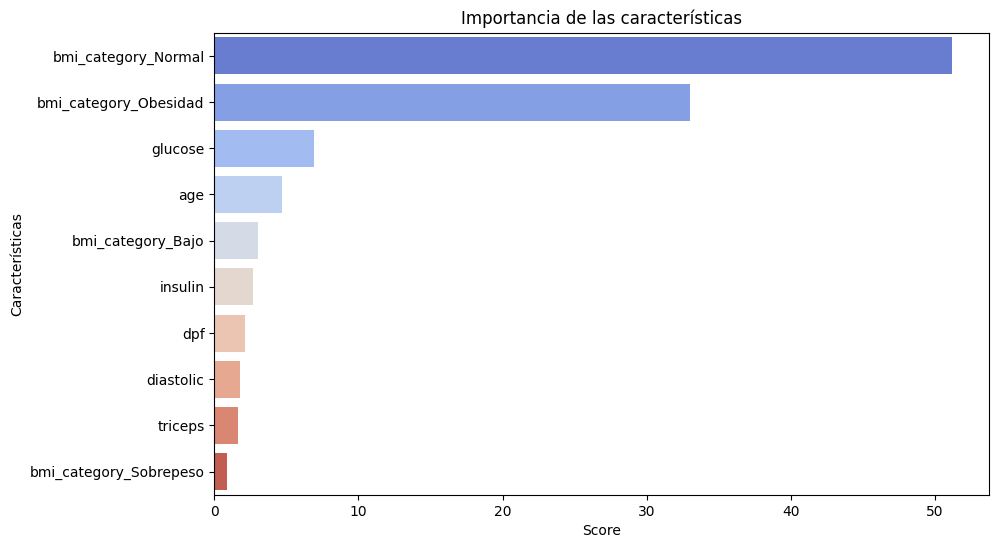

In [149]:
import pandas as pd
from sklearn.feature_selection import SelectKBest, chi2

# Extrae los nombres de las columnas
feature_names = x_names

# Selecciona las mejores características con SelectKBest
k_best = SelectKBest(score_func=chi2, k='all')

# Ajusta el selector a los datos
k_best.fit(X_train, y_train)

# Obtener los índices de las características seleccionadas
selected_features = k_best.get_support(indices=True)

# Obtener los scores
scores = k_best.scores_

# Crear un DataFrame con los scores y los nombres de las características
features_scores = pd.DataFrame({
    'Feature': feature_names,
    'Score': scores
})

# Filtrar solo las características seleccionadas
features_scores = features_scores.loc[selected_features]

# Ordenar por score de mayor a menor
features_scores_graph = features_scores.sort_values(by='Score', ascending=False)

# Graficar
plt.figure(figsize=(10, 6))
sns.barplot(x='Score', y='Feature', data=features_scores_graph, palette='coolwarm')
plt.title('Importancia de las características')
plt.xlabel('Score')
plt.ylabel('Características')
plt.show()

Seleccionemos las primeras 6 características (mayor score)

In [150]:
caracteristicas=features_scores_graph.head(6)['Feature'].tolist()

In [151]:
X_train = X_train[caracteristicas]
X_val = X_val[caracteristicas]
X_test = X_test[caracteristicas]

## Entrenamiento de los modelos

### Busqueda de hiperparámetros y Selección del mejor modelo

In [152]:
best_model_2, scoring_2, score_train_2, score_val_2  = train_and_evaluate_models(models, X_train, y_train, X_val, y_val, scoring='recall', n_iter=50, cv=5)

Entrenando: KNeighbors
Mejores hiperparámetros para KNeighbors: {'weights': 'distance', 'n_neighbors': 11, 'leaf_size': 30, 'algorithm': 'ball_tree'}
Mejor recall-score: 0.8375395748530077

Entrenando: LogisticRegression
Mejores hiperparámetros para LogisticRegression: {'solver': 'saga', 'penalty': 'l2', 'max_iter': 1000, 'C': 0.01}
Mejor recall-score: 0.8796472184531886

Entrenando: DecisionTree
Mejores hiperparámetros para DecisionTree: {'min_samples_split': 15, 'min_samples_leaf': 1, 'max_depth': 3, 'criterion': 'gini'}
Mejor recall-score: 0.8855721393034827

Entrenando: RandomForest
Mejores hiperparámetros para RandomForest: {'n_estimators': 180, 'min_samples_split': 2, 'max_features': 'sqrt', 'max_depth': 9, 'criterion': 'entropy', 'bootstrap': False}
Mejor recall-score: 0.8315241971958389

Entrenando: SVC
Mejores hiperparámetros para SVC: {'kernel': 'linear', 'gamma': 0.1, 'degree': 3, 'C': 0.1}
Mejor recall-score: 0.8886024423337856

Entrenando: GaussianNB
Mejores hiperparámetro

## Validación del modelo escogido

In [153]:
print(f"{scoring_2}-score en el conjunto de entrenamiento: {score_train_2}")
print(f"{scoring_2}-score en el conjunto de validación: {score_val_2}")


recall-score en el conjunto de entrenamiento: 0.9759036144578314
recall-score en el conjunto de validación: 0.9473684210526315


### Matrices de confusión

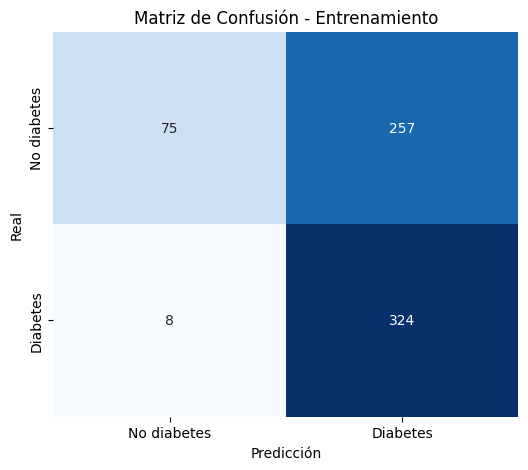

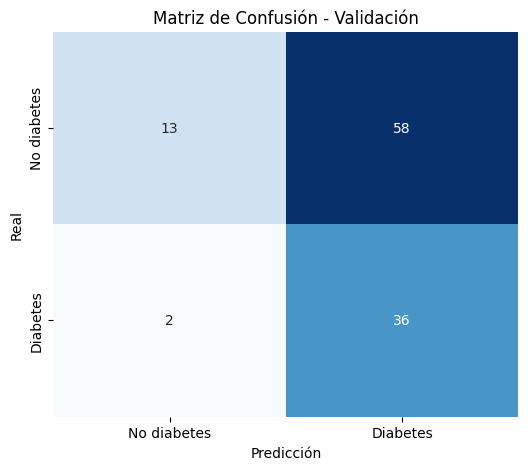

In [154]:
# Calcular las matrices de confusión
cm_train = confusion_matrix(y_train, best_model_2.predict(X_train))
cm_val = confusion_matrix(y_val, best_model_2.predict(X_val))

# Función para graficar la matriz de confusión
def plot_confusion_matrix(cm, title='Matriz de Confusión'):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['No diabetes', 'Diabetes'],
                yticklabels=['No diabetes', 'Diabetes'])
    plt.title(title)
    plt.xlabel('Predicción')
    plt.ylabel('Real')
    plt.show()

# Graficar las matrices de confusión
plot_confusion_matrix(cm_train, title='Matriz de Confusión - Entrenamiento')
plot_confusion_matrix(cm_val, title='Matriz de Confusión - Validación')

### Cross Validation

In [155]:
z_2 = cross_val_score(best_model_2, X_train, y_train, cv = ShuffleSplit(n_splits=10, test_size=0.3),scoring=scoring_2)
print (z_2)
print ("test score  %.3f (±%.4f)"%(np.mean(z_2), np.std(z_2)))

[0.96907216 0.97115385 0.97142857 0.98019802 0.97029703 0.95918367
 0.96629213 0.99       0.98979592 0.98076923]
test score  0.975 (±0.0096)


### Boostraping

In [156]:
(trmean_2, trstd_2), (tsmean_2, tsstd_2) = bootstrap_score(best_model_2, X_train, y_train, test_size=0.3, scoring=scoring_2)
print ("train score %.3f (±%.4f)"%(trmean_2, trstd_2))
print ("test score  %.3f (±%.4f)"%(tsmean_2, tsstd_2))

train score 0.977 (±0.0063)
test score  0.972 (±0.0157)


## Rendimiento

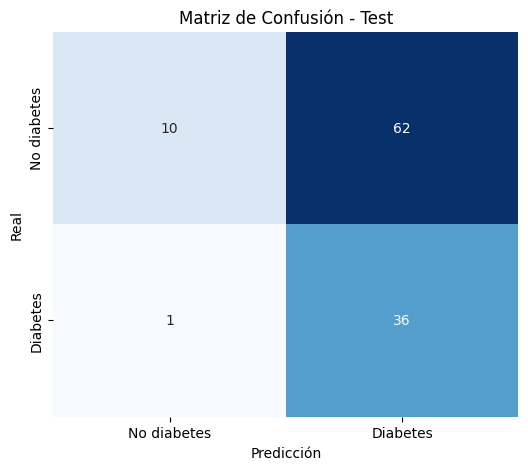

In [157]:
cm_test = confusion_matrix(y_test, best_model_2.predict(X_test))
plot_confusion_matrix(cm_test, title='Matriz de Confusión - Test')

In [158]:
final_score_2 = get_metric_score(y_test,best_model_2.predict(X_test), scoring=scoring_2)
print(f"{scoring_2}-score: {final_score_2:.2f}")

recall-score: 0.97


In [159]:
print(f"{scoring_2}-score en el conjunto de entrenamiento: {get_metric_score(y_train,best_model_2.predict(X_train), scoring_2)}")
print(f"{scoring_2}-score en el conjunto de test: {final_score_2}")

print("Validacion cruzada: %.3f (±%.4f)"%(trmean_2, trstd_2))

recall-score en el conjunto de entrenamiento: 0.9759036144578314
recall-score en el conjunto de test: 0.972972972972973
Validacion cruzada: 0.977 (±0.0063)


# Calibración 3: Reducción de dimensionalidad - Recall
A continuación, repetimos el proceso anterior entrenando los modelos haciendo una transformación en los datos.

## División de datos para entrenamiento, validación y prueba

In [160]:
# Dividimos el conjunto de datos
train_set, val_set, test_set = train_val_test_split(df_final, stratify='diabetes')

X_train, y_train = remove_labels(train_set, 'diabetes')
X_val, y_val = remove_labels(val_set, 'diabetes')
X_test, y_test = remove_labels(test_set, 'diabetes')

In [161]:
print(f"Dimensiones conjuntos de entrenamiento: {X_train.shape}, {y_train.shape}")
print(f"Dimensiones conjuntos de validacion: {X_val.shape}, {y_val.shape}")
print(f"Dimensiones conjuntos de test: {X_test.shape}, {y_test.shape}")

Dimensiones conjuntos de entrenamiento: (506, 10), (506,)
Dimensiones conjuntos de validacion: (109, 10), (109,)
Dimensiones conjuntos de test: (109, 10), (109,)


## Balanceo de datos

Realizamos con el balanceo via Oversampling

In [162]:
conteo_prebal(y_train)

Cantidad de etiquetas '0': 332, (65.61%)
Cantidad de etiquetas '1': 174, (34.39%)


In [163]:
os = SVMSMOTE(random_state=42)
X_train, y_train= os.fit_resample(X_train, y_train)

In [164]:
conteo_prebal(y_train)

Cantidad de etiquetas '0': 332, (50.0%)
Cantidad de etiquetas '1': 332, (50.0%)


## Análisis PCA

In [165]:
# Recordemos que ya tenemos la división en 3 subconjuntos de la información
X_train.shape

(664, 10)

DataFrame con la varianza explicada y acumulada por cada componente principal:
  Componente Principal  Varianza Explicada  Varianza Acumulada
0                  PC1            0.486820            0.486820
1                  PC2            0.254864            0.741685
2                  PC3            0.072708            0.814392
3                  PC4            0.054964            0.869357
4                  PC5            0.031816            0.901172
5                  PC6            0.028604            0.929776
6                  PC7            0.026452            0.956228
7                  PC8            0.022847            0.979076
8                  PC9            0.014801            0.993877
9                 PC10            0.006123            1.000000


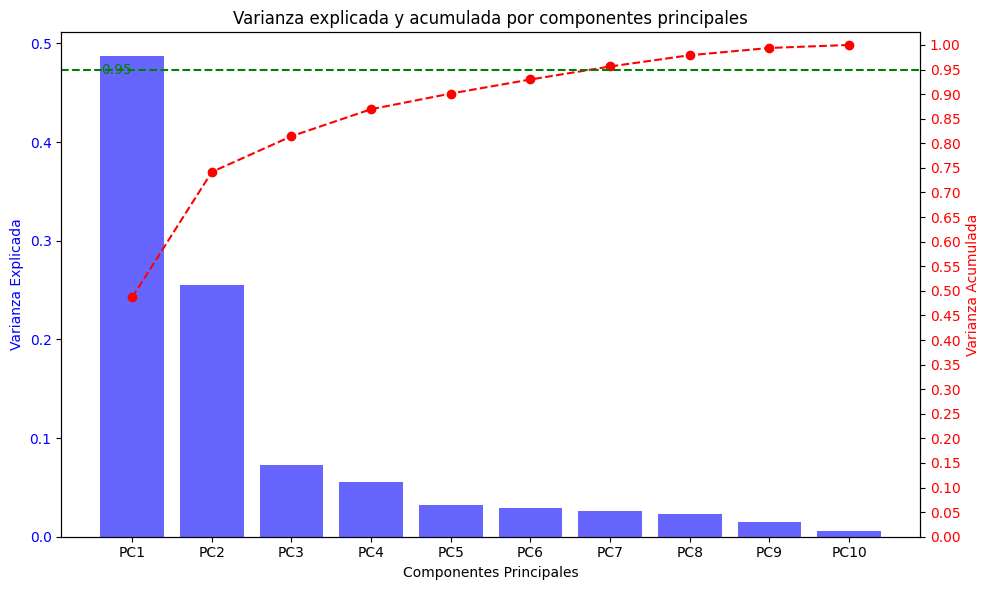

In [166]:
df_componentes, df_varianza, pca, escalador = aplicar_pca(X_train, n_componentes=10)

# Mostrar la varianza explicada por cada componente principal
print('DataFrame con la varianza explicada y acumulada por cada componente principal:')
print(df_varianza)

# Graficar la varianza explicada y la varianza acumulada
fig, ax1 = plt.subplots(figsize=(10, 6))

# Barras para la varianza explicada
ax1.bar(df_varianza['Componente Principal'], df_varianza['Varianza Explicada'], color='b', alpha=0.6)
ax1.set_xlabel('Componentes Principales')
ax1.set_ylabel('Varianza Explicada', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Línea para la varianza acumulada
ax2 = ax1.twinx()
ax2.plot(df_varianza['Componente Principal'], df_varianza['Varianza Acumulada'], color='r', marker='o', linestyle='--')
ax2.set_ylabel('Varianza Acumulada', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Dibujar una línea horizontal en el valor 0.95
ax2.axhline(y=0.95, color='g', linestyle='--')
ax2.text(0, 0.95, '0.95', color='g', va='center', ha='right')

# Establecer los ticks del eje y del segundo eje en incrementos de 0.01
ax2.set_yticks(np.arange(0, 1.05, 0.05))

plt.title('Varianza explicada y acumulada por componentes principales')
fig.tight_layout()
plt.show()



Seleccionamos las componentes cuya varianza explicada acumulada es hasta 95%, es decir, las primeras 6 componentes

In [167]:
X_train_pca = transformar_conjunto(X_train, escalador, pca, n_componentes=6)
X_val_pca = transformar_conjunto(X_val, escalador, pca, n_componentes=6)
X_test_pca = transformar_conjunto(X_test, escalador, pca, n_componentes=6)

In [168]:
# Mostrar un resumen de los datos transformados
print(X_train_pca.head())
print(X_val_pca.head())
print(X_test_pca.head())

        PC1       PC2       PC3       PC4       PC5       PC6
0  0.603048  0.967394 -0.001854  0.142144 -0.041187 -0.041214
1  0.609952  0.986017 -0.007402 -0.020089  0.147872 -0.223632
2 -0.408542 -0.012021 -0.063555 -0.074835  0.095542  0.044114
3  0.979692 -0.375743 -0.166399 -0.067069  0.071789  0.018236
4  0.615806  0.977956  0.413241  0.050549 -0.074878 -0.061259
        PC1       PC2       PC3       PC4       PC5       PC6
0 -0.450219 -0.049218  0.309657  0.318100  0.025513  0.021635
1 -0.395898 -0.007529  0.039793 -0.109633 -0.031065  0.210671
2  0.985108 -0.371887 -0.077320 -0.078204 -0.009781  0.183869
3  0.946801 -0.394687  0.121940  0.085779  0.117526  0.098401
4 -0.403266 -0.010933 -0.062290 -0.016940  0.097439 -0.181032
        PC1       PC2       PC3       PC4       PC5       PC6
0 -0.406481 -0.013513 -0.144258 -0.014513  0.054981 -0.000207
1  0.599097  0.962726  0.096081  0.181458  0.038119 -0.296632
2 -0.424468 -0.027756 -0.187869  0.183086  0.062204 -0.064541
3  0.950

## Entrenamiento de los modelos

Una vez seleccionadas las características, procedemos con el entrenamiento de los modelos, para ello, utilizaremos Random_Search para encontrar los mejores hiperparámetros de cada modelo, y usando la metrica RECALL=True Positive/(True positive + False Negative), calibraremos y escogeremos el mejor modelo.

La razón por la cual escojemos la metrica RECALL, es para poder controlar correctamente los falsos negativos, es decir, pacientes propensos a desarrollar diabetes pero que el modelo los clasifica como no propensos a desarrollar diabetes, con esto tenemos mas chances de predecir un diagnóstico correcto y poder hablar de medicina preventiva.

### Busqueda de hiperparámetros y Selección del mejor modelo

### Selección del mejor modelo

In [169]:
best_model_3, scoring_3, score_train_3, score_val_3  = train_and_evaluate_models(models, X_train_pca, y_train, X_val_pca, y_val, scoring='recall', n_iter=50, cv=5)

Entrenando: KNeighbors
Mejores hiperparámetros para KNeighbors: {'weights': 'distance', 'n_neighbors': 11, 'leaf_size': 30, 'algorithm': 'ball_tree'}
Mejor recall-score: 0.8284486657620986

Entrenando: LogisticRegression
Mejores hiperparámetros para LogisticRegression: {'solver': 'saga', 'penalty': 'l2', 'max_iter': 1000, 'C': 0.01}
Mejor recall-score: 0.8766621438263229

Entrenando: DecisionTree
Mejores hiperparámetros para DecisionTree: {'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 4, 'criterion': 'entropy'}
Mejor recall-score: 0.843374038896427

Entrenando: RandomForest
Mejores hiperparámetros para RandomForest: {'n_estimators': 14, 'min_samples_split': 2, 'max_features': 'sqrt', 'max_depth': 6, 'criterion': 'gini', 'bootstrap': False}
Mejor recall-score: 0.8132519222071461

Entrenando: SVC
Mejores hiperparámetros para SVC: {'kernel': 'poly', 'gamma': 10, 'degree': 4, 'C': 0.001}
Mejor recall-score: 0.9156037991858887

Entrenando: GaussianNB
Mejores hiperparámetros pa

## Validación del modelo escogido

In [170]:
print(f"{scoring_3}-score en el conjunto de entrenamiento: {score_train_3}")
print(f"{scoring_3}-score en el conjunto de validación: {score_val_3}")

recall-score en el conjunto de entrenamiento: 0.9518072289156626
recall-score en el conjunto de validación: 0.8947368421052632


### Matrices de confusión

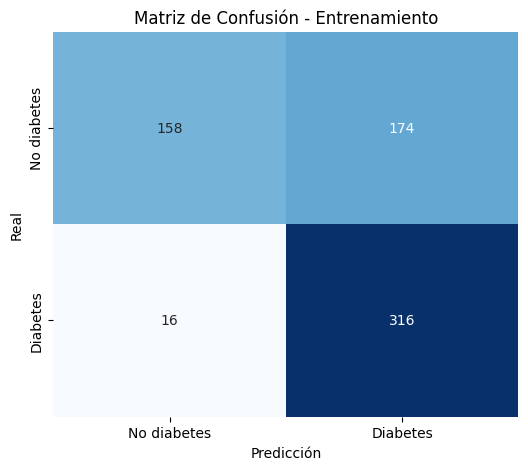

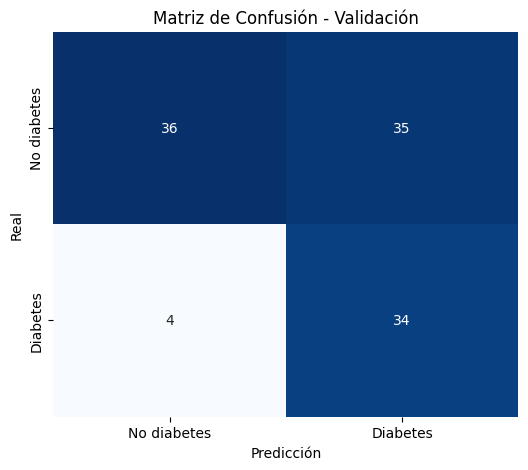

In [171]:
# Calcular las matrices de confusión
cm_train = confusion_matrix(y_train, best_model_3.predict(X_train_pca))
cm_val = confusion_matrix(y_val, best_model_3.predict(X_val_pca))

# Función para graficar la matriz de confusión
def plot_confusion_matrix(cm, title='Matriz de Confusión'):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['No diabetes', 'Diabetes'],
                yticklabels=['No diabetes', 'Diabetes'])
    plt.title(title)
    plt.xlabel('Predicción')
    plt.ylabel('Real')
    plt.show()

# Graficar las matrices de confusión
plot_confusion_matrix(cm_train, title='Matriz de Confusión - Entrenamiento')
plot_confusion_matrix(cm_val, title='Matriz de Confusión - Validación')

### Cross Validation

In [172]:
z_3 = cross_val_score(best_model_3, X_train_pca, y_train, cv = ShuffleSplit(n_splits=10, test_size=0.3),scoring=scoring_3)
print (z_3)
print ("test score  %.3f (±%.4f)"%(np.mean(z_3), np.std(z_3)))

[0.93877551 0.93203883 0.93203883 0.94680851 0.96078431 0.94059406
 0.92156863 0.97727273 0.97029703 0.94505495]
test score  0.947 (±0.0169)


### Boostraping

In [173]:
(trmean_3, trstd_3), (tsmean_3, tsstd_3) = bootstrap_score(best_model_3, X_train_pca, y_train, test_size=0.3, scoring=scoring_3)
print ("train score %.3f (±%.4f)"%(trmean_3, trstd_3))
print ("test score  %.3f (±%.4f)"%(tsmean_3, tsstd_3))

train score 0.954 (±0.0083)
test score  0.946 (±0.0260)


## Rendimiento

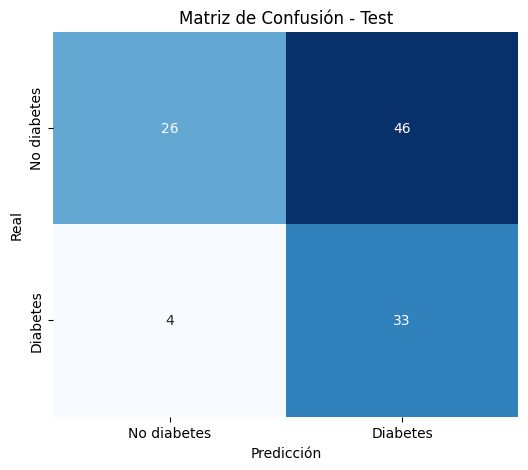

In [174]:
cm_test = confusion_matrix(y_test, best_model_3.predict(X_test_pca))
plot_confusion_matrix(cm_test, title='Matriz de Confusión - Test')

In [175]:
final_score_3 = get_metric_score(y_test,best_model_3.predict(X_test_pca), scoring=scoring_3)
print(f"{scoring_3}-score: {final_score_3:.2f}")

recall-score: 0.89


In [176]:
print(f"{scoring_3}-score en el conjunto de entrenamiento: {get_metric_score(y_train,best_model_3.predict(X_train_pca), scoring=scoring_3)}")
print(f"{scoring_3}-score en el conjunto de test: {final_score_3}")

print("Validacion cruzada: %.3f (±%.4f)"%(trmean_3, trstd_3))

recall-score en el conjunto de entrenamiento: 0.9427710843373494
recall-score en el conjunto de test: 0.8918918918918919
Validacion cruzada: 0.954 (±0.0083)


## Comparación con herramienta tradicional (No ML)

FINDRISC es un cuestionario para identificar individuos con alto riesgo de desarrollar DM2, y fue creado en Finlandia utilizando una cohorte prospectiva de individuos de entre 35 y 64 años. Las preguntas originales incluían edad, índice de masa corporal, circunferencia de la cintura, actividad física, consumo diario de frutas, bayas o verduras, antecedentes de tratamiento con fármacos antihipertensivos y antecedentes de glucosa alta en sangre . Sin embargo, estudios posteriores añadieron antecedentes familiares de DM2 al modelo y modificaron los patrones de dieta y las preguntas sobre actividad física. A pesar de ser ampliamente utilizado para estimar el riesgo de desarrollar diabetes mellitus tipo 2. Este puntaje se usa ampliamente en muchos entornos de América Latina e incluso se ha descrito un FINDRISC de América Latina (LA-FINDRISC).

Resulta interesante realizar una comparación entre la herramienta tradicional y el modelo propuesto.

Utilizando el estudio documentado en : Diagnostic accuracy of the Finnish Diabetes Risk Score (FINDRISC) for undiagnosed T2DM in Peruvian population (tomado de https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6249987/ el 30 de julio de 2024).

Se observan los siguientes resultados para FINDRISC:

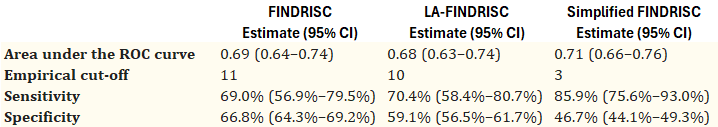



Importante tener en cuenta que la sensibilidad corresponde al Recall para la correpondiente comparación.

## Conclusiones

1. Los modelos analíticos deben considerase como ayuda en la toma de decisiones del personal médico mas no como la verdad absoluta sobre el diagnostico de un paciente.

2. Los modelos deben probarse en ambientes controlados y sin que esto represente inicialmente, y bajo ninguna excepción un dictamen médico, por lo anterior las pruebas en campo deberán buscar y contrastar datos reales (pacientes con toma de prueba de glicemia), contra las predicciones de los modelos con el objetivo de contrastar y comprobar la generalización del modelo.

3. A pesar que el modelo cuenta con menos variables comparado con una herramienta tradicional como FINDRICS, obtuvo mejores resultados, lo cual puede ser un indicador que este tipo de modelos ofrecen una buena solución al problema propuesto.